# Github Repo
https://github.com/jack12324/DL4H-Team-15-final-project/tree/main

#Introduction:


The problem that we are investigating is that current menthods of deep learning using EHR data fail to utilize the information contained within the EHR data fully as only structured data or unstructured clincal notes are used separately. The challenege of the problem is to combine both the unstructured data and structured data found in EHRs to enchance the predicive ability of deep learning in patient care.

The paper we are investigating, “Improving clinical outcome predictions using convolution over medical entities with multimodal learning”, proposes a convolution based deep learning model that can utilize both structured and unstructured data to perform better risk prediction than if the data was used independently of each other. The paper introduces this model and then compares is performance to two other models that use structured data and unstructured data indepentently on the specific problems of mortaility risk prediction and LOS prediction.

# Scope of Reproducibility:

Hypothesis 1: Integrating structured data from EHR notes with entities extracted from clinical notes can improve the prediction of medical outcomes.

The model proposed to the paper is going to be untilized in the prediction tasks of mortality risk prediction and ICU length of stay. The proposed model's performance is going to be compared to two other models, one using just medical entities and one using only stuctured data to gauge its effectiveness on the prediction tasks.


# Methodology


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# import  packages you need
!python --version

import numpy as np
import pandas as pd
import os
import csv
from google.colab import drive
import gc
import re
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')

# import spacy

from gensim.models import Word2Vec, FastText
import collections

import warnings
warnings.filterwarnings('ignore')


Python 3.10.12


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Define Paths
DATAPATH = "/content/drive/MyDrive/Colab Notebooks/Data/"
PP_DP = DATAPATH +"pre-process/"
PP_STEP1_DP = PP_DP+"01-Extract-Timeseries-Features/"
PP_STEP2_DP = PP_DP+"02-Select-SubClinicalNotes/"
PP_STEP3_DP = PP_DP+"03-Preprocess-Clinical-Notes/"
PP_STEP4_DP = PP_DP+"04-Apply-med7-on-Clinical-Notes/"
PP_STEP5_DP = PP_DP+"05-Represent-Entities-With-Different-Embeddings/"
PP_STEP6_DP = PP_DP+"06-Create-Timeseries-Data/"
EMBEDDING_MODEL_DP = DATAPATH + 'embedding-models/'
TRAINING_DP = DATAPATH + 'training_results/'
PRETRAINED_MODEL_DP = DATAPATH+ "pretrained_models/"
EVALPATH = DATAPATH+"eval_results/"
PRELOADED_EVAL_DP = DATAPATH + "preloaded_eval/"

In [ ]:
# Install med7 model
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

import spacy

In [ ]:
import gdown

if not os.path.exists(EMBEDDING_MODEL_DP):
  pretrained_url = 'https://drive.google.com/drive/folders/176q9f8_Z02VDQ372EQB-zDbnX6nymNmb?usp=sharing'
  gdown.download_folder(pretrained_url, output=DATAPATH)

if not os.path.exists(PRETRAINED_MODEL_DP):
  pretrained_url = 'https://drive.google.com/drive/folders/1M1Q5DAa1OY1goYRn1QyOBSz4UH5hPXzm?usp=drive_link'
  gdown.download_folder(pretrained_url, output=DATAPATH)

if not os.path.exists(PRELOADED_EVAL_DP):
  pretrained_url = 'https://drive.google.com/drive/folders/1xKlbPjIU97LmDdbaV0SzTEbYH1mn2zMI?usp=drive_link'
  gdown.download_folder(pretrained_url, output=DATAPATH)

In [7]:
def setup_directories():
  if not os.path.exists(PP_DP):
    os.mkdir(PP_DP)
  if not os.path.exists(PP_STEP1_DP):
    os.mkdir(PP_STEP1_DP)
  if not os.path.exists(PP_STEP2_DP):
    os.mkdir(PP_STEP2_DP)
  if not os.path.exists(PP_STEP3_DP):
    os.mkdir(PP_STEP3_DP)
  if not os.path.exists(PP_STEP4_DP):
    os.mkdir(PP_STEP4_DP)
  if not os.path.exists(PP_STEP5_DP):
    os.mkdir(PP_STEP5_DP)
  if not os.path.exists(PP_STEP6_DP):
    os.mkdir(PP_STEP6_DP)
  if not os.path.exists(TRAINING_DP):
    os.mkdir(TRAINING_DP)
  if not os.path.exists(EVALPATH):
    os.mkdir(EVALPATH)

setup_directories()

## Data Pre-processing

This section contains the pre-processing code provided in https://github.com/tanlab/ConvolutionMedicalNer

No environment information was provided so we needed to adapt it slightly to work with the python 3.10 runtime environment in this notebook.

Please read the comment in the following code block to understand this section

In [8]:
# These global variables control pre-processing.
#
# PRE_PROCESS decides if we run pre-processing If PRE_PROCESS is false,
# we will skip pre-processing. This is generally done after you have run
# pre-processing once and all of the required data is already in your drive.
# note that processing the data is an expensive and time-consuming operation.
#
# DEMO decides the extent of the data used. If True we truncate the various data
# sets to a fraction of their true size to showcase the processing code works
# without spending hours on it

PRE_PROCESS = False
DEMO = True

if not PRE_PROCESS:
  print('PRE_PROCESS must be set to True for the intial run of the notbook, unless pre-processed data is already loaded')

PRE_PROCESS must be set to True for the intial run of the notbook, unless pre-processed data is already loaded


### 01-Extract-Timeseries-Features

In [ ]:
MIMIC_EXTRACT_DATA = DATAPATH+"all_hourly_data.h5"

GAP_TIME          = 6  # In hours
WINDOW_SIZE       = 24 # In hours
SEED              = 10
ID_COLS           = ['subject_id', 'hadm_id', 'icustay_id']
GPU               = '2'

os.environ['CUDA_VISIBLE_DEVICES'] = GPU
np.random.seed(SEED)

def simple_imputer(df):
    idx = pd.IndexSlice
    df = df.copy()
    if len(df.columns.names) > 2: df.columns = df.columns.droplevel(('label', 'LEVEL1', 'LEVEL2'))

    df_out = df.loc[:, idx[:, ['mean', 'count']]]
    icustay_means = df_out.loc[:, idx[:, 'mean']].groupby(ID_COLS).mean()

    df_out.loc[:,idx[:,'mean']] = df_out.loc[:,idx[:,'mean']].groupby(ID_COLS).fillna(
        method='ffill'
    ).groupby(ID_COLS).fillna(icustay_means).fillna(0)

    df_out.loc[:, idx[:, 'count']] = (df.loc[:, idx[:, 'count']] > 0).astype(float)
    df_out.rename(columns={'count': 'mask'}, level='Aggregation Function', inplace=True)

    is_absent = (1 - df_out.loc[:, idx[:, 'mask']])
    hours_of_absence = is_absent.cumsum()
    time_since_measured = hours_of_absence - hours_of_absence[is_absent==0].fillna(method='ffill')
    time_since_measured.rename(columns={'mask': 'time_since_measured'}, level='Aggregation Function', inplace=True)

    df_out = pd.concat((df_out, time_since_measured), axis=1)
    df_out.loc[:, idx[:, 'time_since_measured']] = df_out.loc[:, idx[:, 'time_since_measured']].fillna(100)

    df_out.sort_index(axis=1, inplace=True)
    return df_out

def extract_timeseries_features():
  MAX_ENTRIES = 35000
  if DEMO:
    print(f"DEMO active, only loading first {MAX_ENTRIES} entries from MIMIC EXTRACT timeseries data")
    data_full_lvl2 = pd.read_hdf(MIMIC_EXTRACT_DATA, "vitals_labs", start=0, stop=MAX_ENTRIES)
    data_full_raw  = pd.read_hdf(MIMIC_EXTRACT_DATA, "vitals_labs", stop=MAX_ENTRIES)
  else:
    data_full_lvl2 = pd.read_hdf(MIMIC_EXTRACT_DATA, "vitals_labs")
    data_full_raw  = pd.read_hdf(MIMIC_EXTRACT_DATA, "vitals_labs")
  statics = pd.read_hdf(MIMIC_EXTRACT_DATA, 'patients')

  Ys = statics[statics.max_hours > WINDOW_SIZE + GAP_TIME][['mort_hosp', 'mort_icu', 'los_icu']]
  Ys['los_3'] = Ys['los_icu'] > 3
  Ys['los_7'] = Ys['los_icu'] > 7
  Ys.drop(columns=['los_icu'], inplace=True)
  Ys.astype(float)

  lvl2, raw = [df[
      (df.index.get_level_values('icustay_id').isin(set(Ys.index.get_level_values('icustay_id')))) &
      (df.index.get_level_values('hours_in') < WINDOW_SIZE)
  ] for df in (data_full_lvl2, data_full_raw)]

  raw.columns = raw.columns.droplevel(level=['LEVEL2'])

  train_frac, dev_frac, test_frac = 0.7, 0.1, 0.2
  lvl2_subj_idx, raw_subj_idx, Ys_subj_idx = [df.index.get_level_values('subject_id') for df in (lvl2, raw, Ys)]
  lvl2_subjects = set(lvl2_subj_idx)
  # assert lvl2_subjects == set(Ys_subj_idx), "Subject ID pools differ!"
  # assert lvl2_subjects == set(raw_subj_idx), "Subject ID pools differ!"

  np.random.seed(SEED)
  subjects, N = np.random.permutation(list(lvl2_subjects)), len(lvl2_subjects)
  N_train, N_dev, N_test = int(train_frac * N), int(dev_frac * N), int(test_frac * N)
  train_subj = subjects[:N_train]
  dev_subj   = subjects[N_train:N_train + N_dev]
  test_subj  = subjects[N_train+N_dev:]

  [(lvl2_train, lvl2_dev, lvl2_test), (raw_train, raw_dev, raw_test), (Ys_train, Ys_dev, Ys_test)] = [
      [df[df.index.get_level_values('subject_id').isin(s)] for s in (train_subj, dev_subj, test_subj)] \
      for df in (lvl2, raw, Ys)
  ]

  idx = pd.IndexSlice
  lvl2_means, lvl2_stds = lvl2_train.loc[:, idx[:,'mean']].mean(axis=0), lvl2_train.loc[:, idx[:,'mean']].std(axis=0)

  lvl2_train.loc[:, idx[:,'mean']] = (lvl2_train.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds
  lvl2_dev.loc[:, idx[:,'mean']] = (lvl2_dev.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds
  lvl2_test.loc[:, idx[:,'mean']] = (lvl2_test.loc[:, idx[:,'mean']] - lvl2_means)/lvl2_stds

  lvl2_train, lvl2_dev, lvl2_test = [
    simple_imputer(df) for df in (lvl2_train, lvl2_dev, lvl2_test)
  ]
  lvl2_flat_train, lvl2_flat_dev, lvl2_flat_test = [
      df.pivot_table(index=['subject_id', 'hadm_id', 'icustay_id'], columns=['hours_in']) for df in (
        lvl2_train, lvl2_dev, lvl2_test
      )
  ]

  for df in lvl2_train, lvl2_dev, lvl2_test: assert not df.isnull().any().any()

  [(Ys_train, Ys_dev, Ys_test)] = [
  [df[df.index.get_level_values('subject_id').isin(s)] for s in (train_subj, dev_subj, test_subj)] \
  for df in (Ys,)
  ]

  pd.to_pickle(lvl2_train, PP_STEP1_DP+"lvl2_imputer_train.pkl")
  pd.to_pickle(lvl2_dev, PP_STEP1_DP+"lvl2_imputer_dev.pkl")
  pd.to_pickle(lvl2_test, PP_STEP1_DP+"lvl2_imputer_test.pkl")

  pd.to_pickle(Ys, PP_STEP1_DP+"Ys.pkl")
  pd.to_pickle(Ys_train, PP_STEP1_DP+"Ys_train.pkl")
  pd.to_pickle(Ys_dev, PP_STEP1_DP+"Ys_dev.pkl")
  pd.to_pickle(Ys_test, PP_STEP1_DP+"Ys_test.pkl")

In [ ]:
if PRE_PROCESS:
  extract_timeseries_features()
else:
  print("PRE_PROCESS set to false, skipping extract_timeseries_features")


### 02-Select-SubClinicalNotes

In [ ]:
def select_sub_clinical_notes():
  Ys = pd.read_pickle(os.path.join(PP_STEP1_DP, "Ys.pkl"))


  patient_ids = [] # store all patient ids
  for each_entry in Ys.index:
      patient_ids.append(each_entry[0])

  MAX_ENTRIES = 10000
  SKIP_ROWS = 300000
  if DEMO:
    print(f"DEMO active, only loading first {MAX_ENTRIES} entries from NOTEEVENTS (MIMIC-III) csv")
    noteevents_df = pd.read_csv(os.path.join(DATAPATH, "NOTEEVENTS.csv"), nrows=MAX_ENTRIES, skiprows = lambda x: x !=0 and x < SKIP_ROWS)
  else:
    noteevents_df = pd.read_csv(os.path.join(DATAPATH, "NOTEEVENTS.csv"))

  print(noteevents_df.shape)

  noteevents_df.groupby(noteevents_df.CATEGORY).agg(['count'])

  note_categories = noteevents_df.groupby(noteevents_df.CATEGORY).agg(['count']).index

  selected_note_types = []
  for each_cat in list(note_categories):
      if each_cat != 'Discharge summary':
          selected_note_types.append(each_cat)


  # Select based on note category

  print(noteevents_df.shape)
  sub_notes = noteevents_df[noteevents_df.CATEGORY.isin(selected_note_types)]
  print(sub_notes.shape)

  # Drop no chart notes

  missing_chardate_index = []
  for each_note in sub_notes.itertuples():
      if isinstance(each_note.CHARTTIME, str):
          continue
      if np.isnan(each_note.CHARTTIME):
          missing_chardate_index.append(each_note.Index)
  print ("{} of notes does not charttime.".format(len(missing_chardate_index)))
  print(sub_notes.shape)

  sub_notes.drop(missing_chardate_index, inplace=True )
  print(sub_notes.shape)

  # Select based on patient id

  sub_notes = sub_notes[sub_notes.SUBJECT_ID.isin(patient_ids)] ## select based on patient id

  # Select based on time limit (24 hours)

  MIMIC_EXTRACT_DATA = DATAPATH+"all_hourly_data.h5"
  stats = pd.read_hdf(MIMIC_EXTRACT_DATA, 'patients')
  TIMELIMIT = 1 # 1day

  new_stats = stats.reset_index()

  new_stats.rename(columns = {"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID"}, inplace=True)

  print(new_stats.shape, sub_notes.shape)

  df_adm_notes = pd.merge(sub_notes[['ROW_ID','SUBJECT_ID','HADM_ID','CHARTTIME', 'CATEGORY', 'TEXT']],
                          new_stats[['SUBJECT_ID','HADM_ID','icustay_id','age','admittime','dischtime', 'deathtime',
                                    'intime', 'outtime', 'los_icu', 'mort_icu', 'mort_hosp', 'hospital_expire_flag',
                                    'hospstay_seq', 'max_hours']],
                          on = ['SUBJECT_ID'],
                          how = 'left')

  df_adm_notes['CHARTTIME'] = pd.to_datetime(df_adm_notes['CHARTTIME'])

  df_less_n = df_adm_notes[((df_adm_notes['CHARTTIME']-df_adm_notes['intime']).dt.total_seconds()/(24*60*60))<TIMELIMIT]

  # Save clinical notes

  pd.to_pickle(df_less_n, PP_STEP2_DP+"sub_notes.p")




In [ ]:
if PRE_PROCESS:
  select_sub_clinical_notes()
else:
  print("PRE_PROCESS set to false, skipping select_sub_clinical_notes")

### 03-Preprocess-Clinical-Notes

In [ ]:
SECTION_TITLES = re.compile(
    r'('
    r'ABDOMEN AND PELVIS|CLINICAL HISTORY|CLINICAL INDICATION|COMPARISON|COMPARISON STUDY DATE'
    r'|EXAM|EXAMINATION|FINDINGS|HISTORY|IMPRESSION|INDICATION'
    r'|MEDICAL CONDITION|PROCEDURE|REASON FOR EXAM|REASON FOR STUDY|REASON FOR THIS EXAMINATION'
    r'|TECHNIQUE'
    r'):|FINAL REPORT',
    re.I | re.M)


def getSentences(t):
    return list(preprocess_mimic(t))

def pattern_repl(matchobj):
    """
    Return a replacement string to be used for match object
    """
    return ' '.rjust(len(matchobj.group(0)))

def clean_text(text):
    """
    Clean text
    """

    # Replace [**Patterns**] with spaces.
    text = re.sub(r'\[\*\*.*?\*\*\]', pattern_repl, text)
    # Replace `_` with spaces.
    text = re.sub(r'_', ' ', text)

    start = 0
    end = find_end(text)
    new_text = ''
    if start > 0:
        new_text += ' ' * start
    new_text = text[start:end]

    # make sure the new text has the same length of old text.
    if len(text) - end > 0:
        new_text += ' ' * (len(text) - end)
    return new_text

def preprocess_mimic(text):
    """
    Preprocess reports in MIMIC-III.
    1. remove [**Patterns**] and signature
    2. split the report into sections
    3. tokenize sentences and words
    4. lowercase
    """
    for sec in split_heading(clean_text(text)):
        for sent in sent_tokenize(sec):
            text = ' '.join(word_tokenize(sent))
            yield text.lower()

def split_heading(text):
    """Split the report into sections"""
    start = 0
    for matcher in SECTION_TITLES.finditer(text):
        # add last
        end = matcher.start()
        if end != start:
            section = text[start:end].strip()
            if section:
                yield section

        # add title
        start = end
        end = matcher.end()
        if end != start:
            section = text[start:end].strip()
            if section:
                yield section

        start = end

    # add last piece
    end = len(text)
    if start < end:
        section = text[start:end].strip()
        if section:
            yield section

def find_end(text):
    """Find the end of the report."""
    ends = [len(text)]
    patterns = [
        re.compile(r'BY ELECTRONICALLY SIGNING THIS REPORT', re.I),
        re.compile(r'\n {3,}DR.', re.I),
        re.compile(r'[ ]{1,}RADLINE ', re.I),
        re.compile(r'.*electronically signed on', re.I),
        re.compile(r'M\[0KM\[0KM')
    ]
    for pattern in patterns:
        matchobj = pattern.search(text)
        if matchobj:
            ends.append(matchobj.start())
    return min(ends)

In [ ]:
def preprocess_clinical_notes():
  clinical_notes = pd.read_pickle(os.path.join(PP_STEP2_DP, "sub_notes.p"))
  print(clinical_notes.shape)

  sub_notes = clinical_notes[clinical_notes.SUBJECT_ID.notnull()]
  sub_notes = sub_notes[sub_notes.CHARTTIME.notnull()]
  sub_notes = sub_notes[sub_notes.TEXT.notnull()]

  print(sub_notes.shape)

  sub_notes = sub_notes[['SUBJECT_ID', 'HADM_ID_y', 'CHARTTIME', 'TEXT']]

  sub_notes['preprocessed_text'] = None

  for each_note in sub_notes.itertuples():
      text = each_note.TEXT
      sub_notes.at[each_note.Index, 'preprocessed_text'] = getSentences(text)

  # Save notes

  pd.to_pickle(sub_notes, os.path.join(PP_STEP3_DP, "preprocessed_notes.p"))



In [ ]:
if PRE_PROCESS:
  preprocess_clinical_notes()
else:
  print("PRE_PROCESS set to false, skipping preprocess_clinical_notes")

### 04-Apply-med7-on-Clinical-Notes

In [ ]:
def apply_med7_on_clinical_notes():
  med7 = spacy.load("en_core_med7_lg")

  preprocessed_df = pd.read_pickle(PP_STEP3_DP+"preprocessed_notes.p")

  preprocessed_df['ner'] = None

  count = 0
  preprocessed_index = {}
  total = len(list(preprocessed_df.itertuples()))
  print(f"Total notes to process: {total}")
  for i in preprocessed_df.itertuples():

      if count % 1000 == 0:
          print(f"{count} of {total} notes processed")

      count += 1
      ind = i.Index
      text = i.preprocessed_text

      all_pred = []
      for each_sent in text:
          try:
              doc = med7(each_sent)
              result = ([(ent.text, ent.label_) for ent in doc.ents])
              if len(result) == 0: continue
              all_pred.append(result)
          except:
              print("error..")
              continue
      preprocessed_df.at[ind, 'ner'] = all_pred

  pd.to_pickle(preprocessed_df, PP_STEP4_DP+"ner_df.p")



In [ ]:
if PRE_PROCESS:
  apply_med7_on_clinical_notes()
else:
  print("PRE_PROCESS set to false, skipping apply_med7_on_clinical_notes")

### 05-Represent-Entities-With-Different-Embeddings

In [ ]:
def mean(a):
    return sum(a) / len(a)

def access_model(model, word):
    # return model[word] for use with gensim < 4.0
    return model.wv[word]

def represent_entities_with_different_embeddings():
  new_notes = pd.read_pickle(PP_STEP4_DP+"ner_df.p") # med7
  w2vec = Word2Vec.load(EMBEDDING_MODEL_DP+"word2vec4.model")
  fasttext = FastText.load(EMBEDDING_MODEL_DP+"fasttext4.model")

  null_index_list = []
  for i in new_notes.itertuples():
      if len(i.ner) == 0:
          null_index_list.append(i.Index)
  new_notes.drop(null_index_list, inplace=True)

  med7_ner_data = {}

  for ii in new_notes.itertuples():

      p_id = ii.SUBJECT_ID
      ind = ii.Index

      try:
          new_ner = new_notes.loc[ind].ner
      except:
          new_ner = []

      unique = set()
      new_temp = []

      for j in new_ner:
          for k in j:

              unique.add(k[0])
              new_temp.append(k)

      if p_id in med7_ner_data:
          for i in new_temp:
              med7_ner_data[p_id].append(i)
      else:
          med7_ner_data[p_id] = new_temp

  pd.to_pickle(med7_ner_data, PP_STEP5_DP+"new_ner_word_dict.pkl")

  data_types = [med7_ner_data]
  data_names = ["new_ner"]

  print(w2vec)
  print(fasttext)

  for data, names in zip(data_types, data_names):
    new_word2vec = {}
    print("w2vec starting..")
    e = 0
    p = 0
    for k,v in data.items():

        patient_temp = []
        for i in v:
            try:
                patient_temp.append(access_model(w2vec, i[0]))
                p+=1
            except:
                e+=1
                avg = []
                num = 0
                temp = []

                if len(i[0].split(" ")) > 1:
                    for each_word in i[0].split(" "):
                        try:
                            temp = access_model(w2vec, each_word)
                            avg.append(temp)
                            num += 1
                        except:
                            pass
                    if num == 0: continue
                    avg = np.asarray(avg)
                    t = np.asarray(list(map(mean, zip(*avg))))
                    patient_temp.append(t)
        if len(patient_temp) == 0: continue
        new_word2vec[k] = patient_temp
    print(f"word2vec pass: {p} error: {e}")

    #############################################################################
    print("fasttext starting..")

    new_fasttextvec = {}

    tt=0
    ttt=0
    for k,v in data.items():

        patient_temp = []

        for i in v:
            try:
                patient_temp.append(access_model(fasttext, i[0]))
                tt+=1
            except:
                ttt+=1
                pass
        if len(patient_temp) == 0: continue
        new_fasttextvec[k] = patient_temp
    print(f"fasttext pass: {tt} error: {ttt}")

    #############################################################################

    print("combined starting..")
    new_concatvec = {}

    for k,v in data.items():
        patient_temp = []
    #     if k != 6: continue
        for i in v:
            w2vec_temp = []
            try:
                w2vec_temp = access_model(w2vec, i[0])
            except:
                avg = []
                num = 0
                temp = []

                if len(i[0].split(" ")) > 1:
                    for each_word in i[0].split(" "):
                        try:
                            temp = access_model(w2vec, each_word)
                            avg.append(temp)
                            num += 1
                        except:
                            pass
                    if num == 0:
                        w2vec_temp = [0] * 100
                    else:
                        avg = np.asarray(avg)
                        w2vec_temp = np.asarray(list(map(mean, zip(*avg))))
                else:
                    w2vec_temp = [0] * 100

            fasttemp = access_model(fasttext, i[0])

            appended = np.append(fasttemp, w2vec_temp, 0)
            patient_temp.append(appended)
        if len(patient_temp) == 0: continue
        new_concatvec[k] = patient_temp

    print(len(new_word2vec), len(new_fasttextvec), len(new_concatvec))
    pd.to_pickle(new_word2vec, PP_STEP5_DP+names+"_word2vec_dict.pkl")
    pd.to_pickle(new_fasttextvec, PP_STEP5_DP+names+"_fasttext_dict.pkl")
    pd.to_pickle(new_concatvec, PP_STEP5_DP+names+"_combined_dict.pkl")

  diff = set(new_fasttextvec.keys()).difference(set(new_word2vec))
  for i in diff:
      del new_fasttextvec[i]
      del new_concatvec[i]
  print (len(new_word2vec), len(new_fasttextvec), len(new_concatvec))
  print(len(new_word2vec[list(new_word2vec.keys())[4]][1]))
  pd.to_pickle(new_word2vec, PP_STEP5_DP+"new_ner"+"_word2vec_limited_dict.pkl")
  pd.to_pickle(new_fasttextvec, PP_STEP5_DP+"new_ner"+"_fasttext_limited_dict.pkl")
  pd.to_pickle(new_concatvec, PP_STEP5_DP+"new_ner"+"_combined_limited_dict.pkl")

In [ ]:
if PRE_PROCESS:
  represent_entities_with_different_embeddings()
else:
  print("PRE_PROCESS set to false, skipping represent_entities_with_different_embeddings")

### 06-Create-Timeseries-Data

In [ ]:
def create_timeseries_data():
  lvl2_train =  pd.read_pickle(PP_STEP1_DP+"lvl2_imputer_train.pkl")
  lvl2_dev =  pd.read_pickle(PP_STEP1_DP+"lvl2_imputer_dev.pkl")
  lvl2_test =  pd.read_pickle(PP_STEP1_DP+"lvl2_imputer_test.pkl")

  Ys =  pd.read_pickle(PP_STEP1_DP+"Ys.pkl")
  Ys_train =  pd.read_pickle(PP_STEP1_DP+"Ys_train.pkl")
  Ys_dev =  pd.read_pickle(PP_STEP1_DP+"Ys_dev.pkl")
  Ys_test =  pd.read_pickle(PP_STEP1_DP+"Ys_test.pkl")

  all_train_ids = set()
  for i in Ys_train.itertuples():
      all_train_ids.add( i.Index[0] )

  all_dev_ids = set()
  for i in Ys_dev.itertuples():
      all_dev_ids.add( i.Index[0] )

  all_test_ids = set()
  for i in Ys_test.itertuples():
      all_test_ids.add( i.Index[0] )

  new_word2vec_dict = pd.read_pickle(PP_STEP5_DP+"new_ner_word2vec_dict.pkl")
  new_keys = set(new_word2vec_dict.keys())
  new_train_ids = sorted(all_train_ids.intersection(new_keys))
  new_dev_ids = sorted(all_dev_ids.intersection(new_keys))
  new_test_ids = sorted(all_test_ids.intersection(new_keys))

  print(len(new_keys))
  print(len(new_train_ids))
  print(len(new_dev_ids))
  print(len(new_test_ids))

  pd.to_pickle(new_train_ids, PP_STEP6_DP+"new_train_ids.pkl")
  pd.to_pickle(new_dev_ids, PP_STEP6_DP+"new_dev_ids.pkl")
  pd.to_pickle(new_test_ids, PP_STEP6_DP+"new_test_ids.pkl")

  data_ids = [(new_train_ids, new_dev_ids, new_test_ids)]
  data_names = ["new"]

  for i, (tr, de, te) in zip(data_names, data_ids):

      y_train = Ys_train.loc[tr]
      y_dev = Ys_dev.loc[de]
      y_test = Ys_test.loc[te]

      sub_train = lvl2_train.loc[tr]
      sub_train = sub_train.loc[:, pd.IndexSlice[:, 'mean']]

      sub_dev = lvl2_dev.loc[de]
      sub_dev = sub_dev.loc[:, pd.IndexSlice[:, 'mean']]

      sub_test = lvl2_test.loc[te]
      sub_test = sub_test.loc[:, pd.IndexSlice[:, 'mean']]

      sub_train = sub_train.values
      sub_dev = sub_dev.values
      sub_test = sub_test.values

      # reshape the data for timeseries prediction
      x_train_lstm = sub_train.reshape(int(sub_train.shape[0] / 24), 24, 104)
      x_dev_lstm = sub_dev.reshape(int(sub_dev.shape[0] / 24), 24, 104)
      x_test_lstm = sub_test.reshape(int(sub_test.shape[0] / 24), 24, 104)


      pd.to_pickle(x_train_lstm, PP_STEP6_DP+i+"_x_train.pkl")
      pd.to_pickle(x_dev_lstm, PP_STEP6_DP+i+"_x_dev.pkl")
      pd.to_pickle(x_test_lstm, PP_STEP6_DP+i+"_x_test.pkl")

      pd.to_pickle(y_train, PP_STEP6_DP+i+"_y_train.pkl")
      pd.to_pickle(y_dev, PP_STEP6_DP+i+"_y_dev.pkl")
      pd.to_pickle(y_test, PP_STEP6_DP+i+"_y_test.pkl")

In [ ]:
if PRE_PROCESS:
  create_timeseries_data()
else:
  print("PRE_PROCESS set to false, skipping create_timeseries_data")

##  Data

This project uses the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) dataset. MIMIC-III is a “large, freely-available database comprising de-identified health-related data associated with over forty thousand patients'' [2]. Though de-identified, you are still required to complete training and apply for access. In order to qualify for access, users must first complete and pass the CITI Program’s “Data or Specimens Only Research.'' Then, users must register for an account on PhysioNet before making an access request.

This project then uses MIMIC-Extract [3], which is an “an open
source data extraction pipeline, to extract structured time series features in MIMIC-III” [1]. Key filters applied by MIMIC-Extract are “eliminat[ing] data from patients younger than 15 years old and where the [length of stay] is between 12 hours and 10 days” [1]. This reduces the cohort from over 46,520 patients to 34,472.


In [69]:
patients = pd.read_csv(DATAPATH+"PATIENTS.csv")
print(f"Patients in original MIMIC-III dataset {len(patients)}")

stats = pd.read_hdf(DATAPATH+'all_hourly_data.h5', 'patients')
print(f"Patients in MIMIC-Extract dataset {len(stats)}")

print(f"\n\nExample of data in MIMIC-Extract dataset:")
stats.head()

Patients in original MIMIC-III dataset 46520
Patients in MIMIC-Extract dataset 34472


Example of data in MIMIC-Extract dataset:


,,,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,discharge_location,fullcode_first,dnr_first,...,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,readmission_30,max_hours
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.526792,Medicare,2101-10-20 19:08:00,HYPOTENSION,2101-10-31 13:58:00,SNF,1.0,0.0,...,2101-10-26 20:43:09,6.064560,EMERGENCY,MICU,0,0,0,1,0,145
4,185777,294638,F,WHITE,47.845047,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,HOME WITH HOME IV PROVIDR,1.0,0.0,...,2191-03-17 16:46:31,1.678472,EMERGENCY,MICU,0,0,0,1,0,40
6,107064,228232,F,WHITE,65.942297,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,HOME HEALTH CARE,1.0,0.0,...,2175-06-03 13:39:54,3.672917,ELECTIVE,SICU,0,0,0,1,0,88
9,150750,220597,M,UNKNOWN/NOT SPECIFIED,41.790228,Medicaid,2149-11-09 13:06:00,HEMORRHAGIC CVA,2149-11-14 10:15:00,DEAD/EXPIRED,1.0,0.0,...,2149-11-14 20:52:14,5.323056,EMERGENCY,MICU,1,1,1,1,0,127
11,194540,229441,F,WHITE,50.148295,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,HOME HEALTH CARE,1.0,0.0,...,2178-04-17 20:21:05,1.584410,EMERGENCY,SICU,0,0,0,1,0,38


Finally, with the [Extract-Timeseries-Features](https://github.com/tanlab/ConvolutionMedicalNer/blob/master/01-Extract-Timeseries-Features.ipynb) script we extract the time series data using only the "first 24 hours of patient’s data after ICU admission and only consider the patients with at least 30 hours of present data" [1]
Using a 70%/10%/20% split we generate train, dev, and test data.

In [70]:
# From https://github.com/tanlab/ConvolutionMedicalNer
lvl2_train_imputer = pd.read_pickle(os.path.join(PP_STEP1_DP, "lvl2_imputer_train.pkl"))
lvl2_dev_imputer = pd.read_pickle(os.path.join(PP_STEP1_DP, "lvl2_imputer_dev.pkl"))
lvl2_test_imputer = pd.read_pickle(os.path.join(PP_STEP1_DP,"lvl2_imputer_test.pkl"))
Ys = pd.read_pickle(os.path.join(PP_STEP1_DP, "Ys.pkl"))

print("Shape of train, dev, test {}, {}, {}.".format((lvl2_train_imputer.shape), (lvl2_dev_imputer.shape), (lvl2_test_imputer.shape)))

patient_ids = [] # store all patient ids
for each_entry in Ys.index:
    patient_ids.append(each_entry[0])

print("Number of total patients {}".format(len(patient_ids)))
print("\n\nExample of training data:")
lvl2_train_imputer.head()


Shape of train, dev, test (402240, 312), (57456, 312), (114960, 312).
Number of total patients 23944


Example of training data:


LEVEL2                                 alanine aminotransferase            \
Aggregation Function                                       mask      mean   
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0                             1.0 -0.251255   
                              1                             0.0 -0.251255   
                              2                             0.0 -0.251255   
                              3                             0.0 -0.251255   
                              4                             0.0 -0.251255   

LEVEL2                                                     albumin            \
Aggregation Function                   time_since_measured    mask      mean   
subject_id hadm_id icustay_id hours_in                                         
3          145834  211552     0                        0.0     1.0 -1.954456   
                              1                        1.0     0.0 -1.954456   
                              2                        2.0     0.0 -1.954456   
                              3                        3.0     0.0 -1.954456   
                              4                        4.0     0.0 -1.954456   

LEVEL2                                                     albumin ascites  \
Aggregation Function                   time_since_measured            mask   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                        0.0             0.0   
                              1                        1.0             0.0   
                              2                        2.0             0.0   
                              3                        3.0             0.0   
                              4                        4.0             0.0   

LEVEL2                                                           \
Aggregation Function                   mean time_since_measured   
subject_id hadm_id icustay_id hours_in                            
3          145834  211552     0         0.0               100.0   
                              1         0.0               100.0   
                              2         0.0               100.0   
                              3         0.0               100.0   
                              4         0.0               100.0   

LEVEL2                                 albumin pleural  ...  \
Aggregation Function                              mask  ...   
subject_id hadm_id icustay_id hours_in                  ...   
3          145834  211552     0                    0.0  ...   
                              1                    0.0  ...   
                              2                    0.0  ...   
                              3                    0.0  ...   
                              4                    0.0  ...   

LEVEL2                                         venous pvo2 weight            \
Aggregation Function                   time_since_measured   mask      mean   
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0                      100.0    0.0  1.013037   
                              1                      100.0    0.0  1.013037   
                              2                      100.0    0.0  1.013037   
                              3                      100.0    0.0  1.013037   
                              4                      100.0    0.0  1.013037   

LEVEL2                                                      \
Aggregation Function                   time_since_measured   
subject_id hadm_id icustay_id hours_in                       
3          145834  211552     0                      100.0   
                              1                      100.0   
                              2                      100.0   
                              3                      100.0   
        

In [71]:
print("Example of target data:")
Ys.head()

Example of target data:


,,,mort_hosp,mort_icu,los_3,los_7
subject_id,hadm_id,icustay_id,,,,
3,145834,211552,0,0,True,False
4,185777,294638,0,0,False,False
6,107064,228232,0,0,True,False
9,150750,220597,1,1,True,False
11,194540,229441,0,0,False,False


In [72]:
Ys_train =  pd.read_pickle(PP_STEP1_DP+"Ys_train.pkl")
Ys_dev =  pd.read_pickle(PP_STEP1_DP+"Ys_dev.pkl")
Ys_test =  pd.read_pickle(PP_STEP1_DP+"Ys_test.pkl")

print("Label hit percentage:")
print("ICU Mortality")
print ("train", sum(Ys_train.mort_icu.values)*1.0 / len(Ys_train.mort_icu.values))
print ("dev", sum(Ys_dev.mort_icu.values)*1.0 / len(Ys_dev.mort_icu.values))
print ("test", sum(Ys_test.mort_icu.values)*1.0 / len(Ys_test.mort_icu.values))
print ("====")
print("Hospital Mortality")
print ("train", sum(Ys_train.mort_hosp.values)*1.0 / len(Ys_train.mort_hosp.values))
print ("dev", sum(Ys_dev.mort_hosp.values)*1.0 / len(Ys_dev.mort_hosp.values))
print ("test", sum(Ys_test.mort_hosp.values)*1.0 / len(Ys_test.mort_hosp.values))
print ("====")
print("Length of Stay > 3")
print ("train", sum(Ys_train.los_3.values)*1.0 / len(Ys_train.los_3.values))
print ("dev", sum(Ys_dev.los_3.values)*1.0 / len(Ys_dev.los_3.values))
print ("test", sum(Ys_test.los_3.values)*1.0 / len(Ys_test.los_3.values))
print ("====")
print("Length of Stay > 7")
print ("train", sum(Ys_train.los_7.values)*1.0 / len(Ys_train.los_7.values))
print ("dev", sum(Ys_dev.los_7.values)*1.0 / len(Ys_dev.los_7.values))
print ("test", sum(Ys_test.los_7.values)*1.0 / len(Ys_test.los_7.values))

Label hit percentage:
ICU Mortality
train 0.07159904534606205
dev 0.06725146198830409
test 0.07432150313152401
====
Hospital Mortality
train 0.10680190930787589
dev 0.09649122807017543
test 0.10855949895615867
====
Length of Stay > 3
train 0.43323389021479713
dev 0.42105263157894735
test 0.4246346555323591
====
Length of Stay > 7
train 0.07696897374701671
dev 0.07268170426065163
test 0.07954070981210856


For the time series data we do a [final bit of processessing](https://github.com/tanlab/ConvolutionMedicalNer/blob/master/06-Create-Timeseries-Data.ipynb) to use ids for which we have clinical notes (following sections) and reshape the data for timeseries prediction

In [73]:

x_test_lstm = pd.read_pickle(PP_STEP6_DP+"new_x_test.pkl")
y_test = pd.read_pickle(PP_STEP6_DP+"new_y_test.pkl")

print(x_test_lstm.shape)
print(y_test.shape)

(4420, 24, 104)
(4420, 4)


For the clinical note portion of this model, we again start with the MIMIC-III dataset. Using the NOTEEVENTS table.

We limit the note data using [Preprocess-Clinical-Notes](https://github.com/tanlab/ConvolutionMedicalNer/blob/master/03-Preprocess-Clinical-Notes.ipynb) which applies the following critera:


*   No dischage notes
*   No notes without a chart time
* No patients without any clinical notes in 24 hours
* notes must be linked to a patient from the time series data

The original dataset has 2,083,180 note entries when grouped by category and aggregated by count, with these filters applied, we end up with 181,483

Due to the size of the dataset we've preprocessed the data, but here is a log documenting the effect of the various filters:

```
Total note events in MIMIC-III dataset 2083180
Notes without 'Discharge summary' category 2023528
256914 of notes have no charttime.
Notes that have a CHARTTIME 1766614
Notes that match timeseries patients 745974
Notes within 24 hours 181483
```

Breakdown of note category prior to filtering:

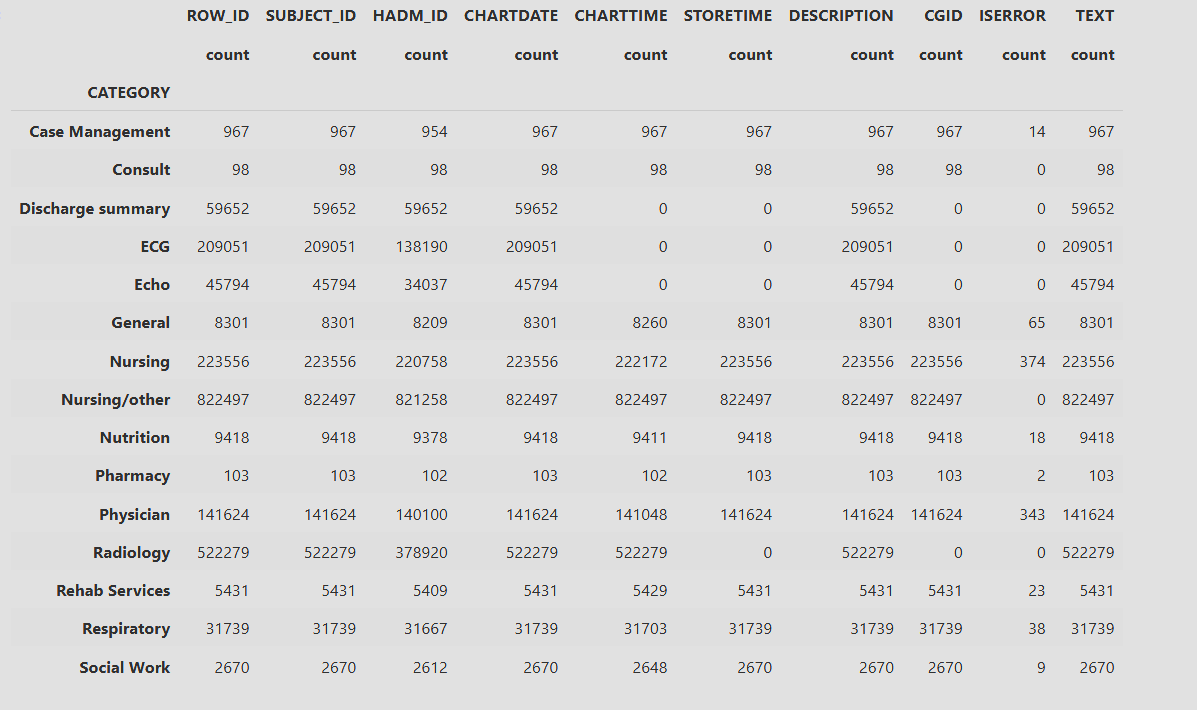

In [74]:

sub_notes = pd.read_pickle(PP_STEP2_DP+"sub_notes.p")
print(f"Final number of notes after criteria applied: {len(sub_notes)}")

print(f"\n\nExample of data:")
sub_notes.head(2)


Final number of notes after criteria applied: 181483


Example of data:


,ROW_ID,SUBJECT_ID,HADM_ID_x,CHARTTIME,CATEGORY,TEXT,HADM_ID_y,icustay_id,age,admittime,dischtime,deathtime,intime,outtime,los_icu,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,max_hours
16,317750,27866,109679.0,2143-04-09 03:22:00,Nursing,Ms. [**Known lastname 1170**] is an 83 yo F w/...,109679,272695,83.424099,2143-04-08 07:15:00,2143-04-15 13:07:00,NaT,2143-04-08 23:38:15,2143-04-10 18:03:41,1.767662,0,0,0,1,42
17,317751,27866,109679.0,2143-04-09 03:22:00,Nursing,Ms. [**Known lastname 1170**] is an 83 yo F w/...,109679,272695,83.424099,2143-04-08 07:15:00,2143-04-15 13:07:00,NaT,2143-04-08 23:38:15,2143-04-10 18:03:41,1.767662,0,0,0,1,42


We then do a further preprocessing step, using [Preprocess-Clinical-Notes](https://github.com/tanlab/ConvolutionMedicalNer/blob/master/03-Preprocess-Clinical-Notes.ipynb) Which confirms the SUBJECT_ID, CHARTTIME, and TEXT fields are not null. It then selects the above columns, plus the HADM_ID_y column, before passing the TEXT field through a [processing script](https://github.com/kaggarwal/ClinicalNotesICU) which     
  1. remove certain patterns and replaces them with spaces
  2. splist the report into sections
  3. tokenizes sentences and words
  4. lowercases words


In [75]:
preprocessed_text = pd.read_pickle(PP_STEP3_DP+"preprocessed_notes.p")
print(f"Length of preprocessed notes (should be same as note count above): {len(preprocessed_text)}")
print("\n\nExample data:")
preprocessed_text.head()

Length of preprocessed notes (should be same as note count above): 181483


Example data:


,SUBJECT_ID,HADM_ID_y,CHARTTIME,TEXT,preprocessed_text
16,27866,109679,2143-04-09 03:22:00,Ms. [**Known lastname 1170**] is an 83 yo F w/...,"[ms. is an 83 yo f w/pmhx sx for cll , hyperte..."
17,27866,109679,2143-04-09 03:22:00,Ms. [**Known lastname 1170**] is an 83 yo F w/...,"[ms. is an 83 yo f w/pmhx sx for cll , hyperte..."
23,29075,179159,2116-02-06 00:25:00,Chief Complaint: GI bleeding\n HPI:\n 67M...,[chief complaint : gi bleeding hpi : 67m w/ h/...
24,29075,179159,2116-02-06 00:25:00,Chief Complaint: GI bleeding\n HPI:\n 67M...,[chief complaint : gi bleeding hpi : 67m w/ h/...
25,29075,179159,2116-02-06 03:50:00,Chief Complaint: GI Bleed\n I saw and exami...,[chief complaint : gi bleed i saw and examined...


In [76]:
print(f"\n\nExample of unprocessed text:\n{preprocessed_text.iloc[0].TEXT}")
print(f"\n\nExample of processed text:\n{preprocessed_text.iloc[0].preprocessed_text}")



Example of unprocessed text:
Ms. [**Known lastname 1170**] is an 83 yo F w/PMHx sx for CLL, hypertension, COPD,
   osteoarthritis, and hyperlipidemia who was admited for an elective
   total hip arthroplasty for persistent right hip pain.  Patient
   initially sustained a right hip fracture after a fall in [**2137**], and had
   an ORIF performed at the time. Since then she has had right hip pain,
   and was found to have AVN of the right femoral head. She was then
   brought in today for elective total hip replacement.
   .
   In the OR today, patient had a conversion of the ORIF to a total hip
   replacement.
   Patient had an estimated 1600 cc EBL, and received 6u pRBC. Her I/Os
   were 7200cc in (3.7L LR, 1.5L pRBCs, 2L NS), with 2500 cc out (1.6L
   EBL, 950 cc UOP). She was hypotensive post-operatively (?80/40 at one
   time point) and was placed on neosynephrine briefly.



Example of processed text:
['ms. is an 83 yo f w/pmhx sx for cll , hypertension , copd , osteoarthritis 

For the final bit of data processing, we pass the clinical notes through a pre-trained NER model, med7 [4] which "extracts seven different named entities such as
’Drug’, ’Strength’, ’Duration’, ’Route’, ’Form’, ’Dosage’, ’Frequency’."

In [77]:
print(len(list(preprocessed_text.itertuples())))

181483


With our clinical notes processed, we can now generate embeddings for said notes per patient.
This paper explores three word embedding methods:
1. word2vec using a [pretrained model](https://github.com/kexinhuang12345/clinicalBERT)
2. fasttext using a [pretrained model](https://github.com/kexinhuang12345/clinicalBERT)
3. a concatination of 1+2

For each method, using [Represent-Entities-With-Different-Embeddings](https://github.com/tanlab/ConvolutionMedicalNer/blob/master/05-Represent-Entities-With-Different-Embeddings.ipynb) we take the embedding of each word, then average them for a low dimension representation
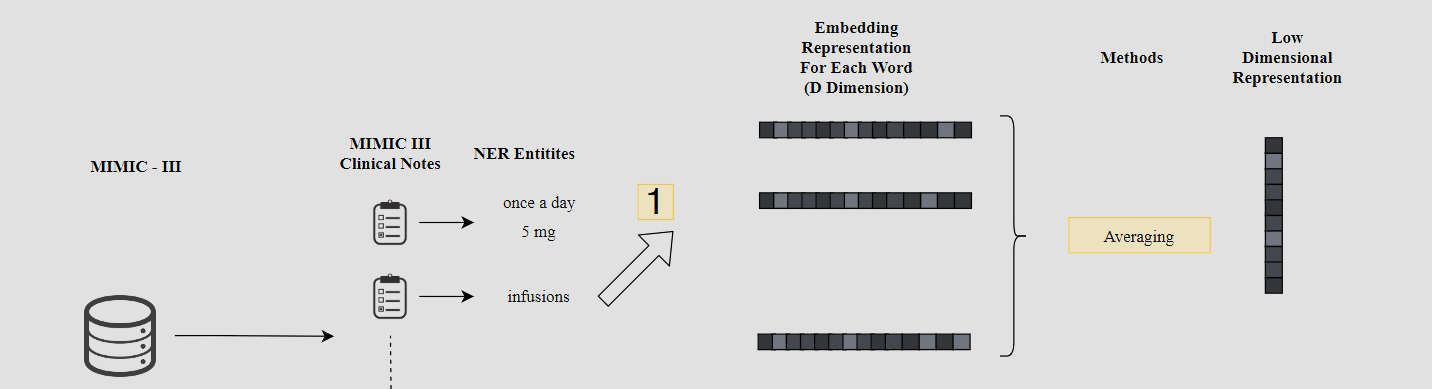

In [78]:
new_word2vec = pd.read_pickle(PP_STEP5_DP+"new_ner_word2vec_limited_dict.pkl")
new_fasttextvec = pd.read_pickle(PP_STEP5_DP+"new_ner_fasttext_limited_dict.pkl")
new_concatvec = pd.read_pickle(PP_STEP5_DP+"new_ner_combined_limited_dict.pkl")

print(f"word2vec embedding number of patients: {len(new_word2vec)}")
print(f"word2vec embedding length: {len(new_word2vec[list(new_word2vec.keys())[0]][0])}")
print(f"\nfasttext embedding number of patients: {len(new_fasttextvec)}")
print(f"fasttext embedding length: {len(new_fasttextvec[list(new_fasttextvec.keys())[0]][0])}")
print(f"\nconcat embedding number of patients: {len(new_concatvec)}")
print(f"concat embedding length: {len(new_concatvec[list(new_concatvec.keys())[0]][0])}")

word2vec embedding number of patients: 22203
word2vec embedding length: 100

fasttext embedding number of patients: 22203
fasttext embedding length: 100

concat embedding number of patients: 22203
concat embedding length: 200


In [79]:
gc.collect()

0

##   Model and Training
Models are trained using the code provided with the paper here: https://github.com/tanlab/ConvolutionMedicalNer/tree/master

Slight modifications were made to allow the code to be compatible with the 3.10 python version provided in this collab notebook.

note that no code was provided for the doc2vec model referenced in the paper so we've omited this model from the notebook and results

We train a number of models in this project. First we train baseline models for timeseries data (GRU/LSTM) and the averaged multimodal modal (with an underlying embedding of word2vec, fasttext, or the concatinated embedding)

### Timeseries Baseline

For the timeseries baseline model, we trained both a GRU and LSTM network from keras with a sigmoid classifier. We expiremented using both a 128 and 256 unit network for each with the following training params:
* batch_size: 128
*max_epocs: 100 (early exit was used if loss didn't improve three consecutive times)
*number_of_iterations: 10 (start seed was randomized with each iteration, The result of each iteration is averaged for the final score)
* loss_function: binary_crossentropy
* optimizer: adam

A separate model is trained for each of the 4 classification problems

In [10]:
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate, Activation, Concatenate, LSTM, GRU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, BatchNormalization, GRU, Convolution1D, LSTM
from tensorflow.keras.layers import UpSampling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPool1D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau
from tensorflow.python.keras.backend import set_session, clear_session, get_session


from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

In [11]:
# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    gc.collect() # if it's done something you should see a number being outputted

def make_prediction_timeseries(model, test_data, verbose=False):
    probs = model.predict(test_data, verbose=verbose)
    y_pred = [1 if i>=0.5 else 0 for i in probs]
    return probs, y_pred

def save_scores_timeseries(predictions, probs, ground_truth, model_name,
                problem_type, iteration, hidden_unit_size, type_of_ner):

    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)


    result_dict = {}
    result_dict['auc'] = auc
    result_dict['auprc'] = auprc
    result_dict['acc'] = acc
    result_dict['F1'] = F1


    file_name = str(hidden_unit_size)+"-"+model_name+"-"+problem_type+"-"+str(iteration)+"-"+type_of_ner+".p"

    pd.to_pickle(result_dict, os.path.join(TRAINING_DP, file_name))

    print(auc, auprc, acc, F1)

In [12]:
def timeseries_model(layer_name, number_of_unit):
    K.clear_session()

    sequence_input = Input(shape=(24,104),  name = "timeseries_input")

    if layer_name == "LSTM":
        x = LSTM(number_of_unit)(sequence_input)
    else:
        x = GRU(number_of_unit)(sequence_input)

    logits_regularizer = tf.keras.regularizers.l2(l=0.01)
    sigmoid_pred = Dense(1, activation='sigmoid',use_bias=False,
                         kernel_initializer=tf.initializers.glorot_uniform(),
                  kernel_regularizer=logits_regularizer)(x)


    model = Model(inputs=sequence_input, outputs=sigmoid_pred)


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [13]:
def train_baseline_timeseries_model():
  type_of_ner = "new"

  x_train_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_train.pkl")
  x_dev_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_dev.pkl")
  x_test_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_test.pkl")

  y_train = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_train.pkl")
  y_dev = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_dev.pkl")
  y_test = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_test.pkl")

  epoch_num = 100
  model_patience = 3
  monitor_criteria = 'val_loss'
  batch_size = 128

  unit_sizes = [128, 256]
  # unit_sizes = [256]
  iter_num = 11
  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
  layers = ["LSTM", "GRU"]
  # layers = ["GRU"]
  for each_layer in layers:
      print("Layer: ", each_layer)
      for each_unit_size in unit_sizes:
          print("Hidden unit: ", each_unit_size)
          for iteration in range(1, iter_num):
              print("Iteration number: ", iteration)
              print("=============================")

              for each_problem in target_problems:
                  print ("Problem type: ", each_problem)
                  print ("__________________")


                  early_stopping_monitor = EarlyStopping(monitor=monitor_criteria, patience=model_patience)
                  best_model_name = TRAINING_DP+str(each_layer)+"-"+str(each_unit_size)+"-"+str(each_problem)+"-"+"best_model.hdf5"
                  checkpoint = ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', period=1)


                  callbacks = [early_stopping_monitor, checkpoint]

                  model = timeseries_model(each_layer, each_unit_size)
                  model.fit(x_train_lstm, y_train[each_problem], epochs=epoch_num, verbose=1,
                            validation_data=(x_dev_lstm, y_dev[each_problem]), callbacks=callbacks, batch_size= batch_size)

                  model.load_weights(best_model_name)

                  probs, predictions = make_prediction_timeseries(model, x_test_lstm)
                  save_scores_timeseries(predictions, probs, y_test[each_problem].values,str(each_layer),
                                        each_problem, iteration, each_unit_size,type_of_ner)
                  reset_keras(model)
                  #del model
                  clear_session()
                  gc.collect()

In [14]:
# Uncomment to re-train model (slow)
# train_baseline_timeseries_model()
gc.collect()

43

### Multimodal Baseline

This model uses a similar GRU unit to the one found in the Timeseries baseline before combining the result with the medical entity data gathered in the data section. More specifically:
* Time series data is processed through one layer GRU layer with
256 hidden units
* Averaged representations of medical entities
are combined with the time-series output
* This representation is fed into fully connected layer with 256 neurons
* a sigmoid classifier
is added to the model.

We only use a 256 sized GRU cell since it performed best in the timeseries baseline. We train a model using each of the three word embedding methods (word2vec, fasttext, and combined) We use training params similar to those of the Timeseries model:
  * batch_size: 64
  * max_epocs: 100 (early exit was used if loss didn't improve five consecutive times)
  * number_of_iterations: 2 (start seed was randomized with each iteration, The result of each iteration is averaged for the final score)
  *  loss_function: binary_crossentropy
  * optimizer: adam

We train a separate model for each of the 4 prediction tasks

In [15]:
def create_dataset(dict_of_ner):
    temp_data = []
    for k, v in sorted(dict_of_ner.items()):
        temp = []
        for embed in v:
          temp.append(embed)
        temp_data.append(np.mean(temp, axis = 0))
    return np.asarray(temp_data)

def make_prediction_multi_avg(model, test_data):
    probs = model.predict(test_data, verbose=False)
    y_pred = [1 if i>=0.5 else 0 for i in probs]
    return probs, y_pred

def save_scores_multi_avg(predictions, probs, ground_truth,

                          embed_name, problem_type, iteration, hidden_unit_size,

                          sequence_name, type_of_ner):

    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)

    result_dict = {}
    result_dict['auc'] = auc
    result_dict['auprc'] = auprc
    result_dict['acc'] = acc
    result_dict['F1'] = F1

    file_name = str(sequence_name)+"-"+str(hidden_unit_size)+"-"+embed_name
    file_name = file_name +"-"+problem_type+"-"+str(iteration)+"-"+type_of_ner+"-avg-.p"
    pd.to_pickle(result_dict, os.path.join(TRAINING_DP, file_name))

    print(auc, auprc, acc, F1)

def avg_ner_model(layer_name, number_of_unit, embedding_name):

    if embedding_name == "concat":
        input_dimension = 200
    else:
        input_dimension = 100

    sequence_input = Input(shape=(24,104))

    input_avg = Input(shape=(input_dimension, ), name = "avg")
#     x_1 = Dense(256, activation='relu')(input_avg)
#     x_1 = Dropout(0.3)(x_1)

    if layer_name == "GRU":
        x = GRU(number_of_unit)(sequence_input)
    elif layer_name == "LSTM":
        x = LSTM(number_of_unit)(sequence_input)

    x = tf.keras.layers.Concatenate()([x, input_avg])

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)


    logits_regularizer = tf.keras.regularizers.l2(l=0.01)

    preds = Dense(1, activation='sigmoid',use_bias=False,
                         kernel_initializer=tf.initializers.glorot_uniform(),
                  kernel_regularizer=logits_regularizer)(x)


    opt = tf.keras.optimizers.legacy.Adam(lr=0.001, decay = 0.01)
    model = Model(inputs=[sequence_input, input_avg], outputs=preds)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])

    return model

In [16]:
def train_multimodal_baseline_model():

  type_of_ner = 'new'
  print("Loading X data")
  x_train_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_train.pkl")
  x_dev_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_dev.pkl")
  x_test_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_test.pkl")

  print("Loading Y data")
  y_train = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_train.pkl")
  y_dev = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_dev.pkl")
  y_test = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_test.pkl")

  print("Loading Embedding data")
  ner_word2vec = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_word2vec_limited_dict.pkl")
  ner_fasttext = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_fasttext_limited_dict.pkl")
  ner_concat = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_combined_limited_dict.pkl")

  print("Loading IDs")
  train_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_train_ids.pkl")
  dev_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_dev_ids.pkl")
  test_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_test_ids.pkl")

  embedding_types = ['word2vec', 'fasttext', 'concat']
  embedding_dict = [ner_word2vec, ner_fasttext, ner_concat]
  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']


  num_epoch = 100
  model_patience = 5
  monitor_criteria = 'val_loss'
  batch_size = 64
  iter_num = 2
  # unit_sizes = [128, 256]
  unit_sizes = [256]

  #layers = ["LSTM", "GRU"]
  layers = ["GRU"]
  for each_layer in layers:
      print ("Layer: ", each_layer)
      for each_unit_size in unit_sizes:
          print ("Hidden unit: ", each_unit_size)

          for embed_dict, embed_name in zip(embedding_dict, embedding_types):
              print ("Embedding: ", embed_name)
              print("=============================")

              temp_train_ner = dict((k, embed_dict[k]) for k in train_ids)
              temp_dev_ner = dict((k, embed_dict[k]) for k in dev_ids)
              temp_test_ner = dict((k, embed_dict[k]) for k in test_ids)

              x_train_ner = create_dataset(temp_train_ner)
              x_dev_ner = create_dataset(temp_dev_ner)
              x_test_ner = create_dataset(temp_test_ner)


              for iteration in range(1, iter_num):
                  print ("Iteration number: ", iteration)

                  for each_problem in target_problems:
                      print ("Problem type: ", each_problem)
                      print ("__________________")

                      early_stopping_monitor = EarlyStopping(monitor=monitor_criteria, patience=model_patience)
                      best_model_name = TRAINING_DP+"avg-"+str(embed_name)+"-"+str(each_problem)+"-"+"best_model.hdf5"
                      checkpoint = ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1,
                          save_best_only=True, mode='min', period=1)


                      callbacks = [early_stopping_monitor, checkpoint]

                      model = avg_ner_model(each_layer, each_unit_size, embed_name)

                      model.fit([x_train_lstm, x_train_ner], y_train[each_problem], epochs=num_epoch, verbose=1,
                                validation_data=([x_dev_lstm, x_dev_ner], y_dev[each_problem]), callbacks=callbacks,
                                batch_size=batch_size )

                      model.load_weights(best_model_name)

                      probs, predictions = make_prediction_multi_avg(model, [x_test_lstm, x_test_ner])

                      save_scores_multi_avg(predictions, probs, y_test[each_problem],
                                 embed_name, each_problem, iteration, each_unit_size,
                                 each_layer, type_of_ner)

                      reset_keras(model)
                      #del model
                      clear_session()
                      gc.collect()



In [17]:
# Uncomment to re-train model (slow)
# train_multimodal_baseline_model()
gc.collect()

0

### Proposed Model

The proposed model of the paper takes the baseline model and adds in Convolutional layers:
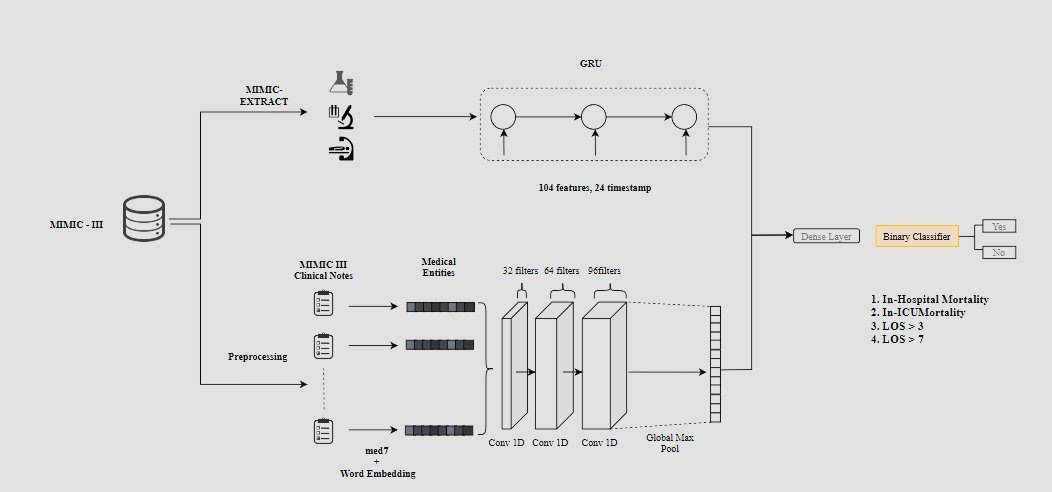

"In our model, K medical entities were extracted from N clinical notes from each patient. These K medical entities are [embedded using one of three methods] Word2Vec, FastText, and a combination of them. These entities ei ∈ R<sup>d</sup> are combined vertically to make a matrix M ∈ R<sup>k∗d</sup>" [1]

This matrix, M is passed through three 1D convolutional layers with subsequent filter sizes of 32, 64, and 96 followed by a max-pooling layer. The results of the CNN are concatinated with the result of the GRU (same as baseline -- 256 hidden units) and fed through a final fully connected layer of 512 hidden units. ReLU is used on the hidden layer before a dropout layer of 20% is applied. A final fully connected layer with a sigmoid classifier provides the binary output.

The training parameters again closely follow the baseline models:
  * batch_size: 64
  * max_epocs: 100 (early exit was used if loss didn't improve five consecutive times)
  * number_of_iterations: 10 (start seed was randomized with each iteration, The result of each iteration is averaged for the final score)
  *  loss_function: binary_crossentropy
  * optimizer: adam

As with the baselines, a separate model is trained for each of the classification problems


In [18]:
def make_prediction_cnn(model, test_data):
    probs = model.predict(test_data, verbose=False)
    y_pred = [1 if i>=0.5 else 0 for i in probs]
    return probs, y_pred

def save_scores_cnn(predictions, probs, ground_truth,

                          embed_name, problem_type, iteration, hidden_unit_size,

                          sequence_name, type_of_ner):

    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)

    result_dict = {}
    result_dict['auc'] = auc
    result_dict['auprc'] = auprc
    result_dict['acc'] = acc
    result_dict['F1'] = F1

    file_name = str(sequence_name)+"-"+str(hidden_unit_size)+"-"+embed_name
    file_name = file_name +"-"+problem_type+"-"+str(iteration)+"-"+type_of_ner+"-cnn-.p"
    pd.to_pickle(result_dict, os.path.join(TRAINING_DP, file_name))

    print(auc, auprc, acc, F1)

def print_scores_cnn(predictions, probs, ground_truth, model_name, problem_type, iteration, hidden_unit_size):
    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)

    print ("AUC: ", auc, "AUPRC: ", auprc, "F1: ", F1)

def get_subvector_data(size, embed_name, data):
    if embed_name == "concat":
        vector_size = 200
    else:
        vector_size = 100

    x_data = {}
    for k, v in data.items():
        number_of_additional_vector = len(v) - size
        vector = []
        for i in v:
            vector.append(i)
        if number_of_additional_vector < 0:
            number_of_additional_vector = np.abs(number_of_additional_vector)

            temp = vector[:size]
            for i in range(0, number_of_additional_vector):
                temp.append(np.zeros(vector_size))
            x_data[k] = np.asarray(temp)
        else:
            x_data[k] = np.asarray(vector[:size])

    return x_data


def proposedmodel(layer_name, number_of_unit, embedding_name, ner_limit, num_filter):
    if embedding_name == "concat":
        input_dimension = 200
    else:
        input_dimension = 100

    sequence_input = Input(shape=(24,104))

    input_img = Input(shape=(ner_limit, input_dimension), name = "cnn_input")

    convs = []
    filter_sizes = [2,3,4]



    text_conv1d = Conv1D(filters=num_filter, kernel_size=3,
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu',
                         kernel_initializer=tf.initializers.glorot_uniform() )(input_img)

    text_conv1d = Conv1D(filters=num_filter*2, kernel_size=3,
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu',
                        kernel_initializer=tf.initializers.glorot_uniform())(text_conv1d)

    text_conv1d = Conv1D(filters=num_filter*3, kernel_size=3,
                 padding = 'valid', strides = 1, dilation_rate=1, activation='relu',
                        kernel_initializer=tf.initializers.glorot_uniform())(text_conv1d)


    #concat_conv = keras.layers.Concatenate()([text_conv1d, text_conv1d_2, text_conv1d_3])
    text_embeddings = GlobalMaxPooling1D()(text_conv1d)
    #text_embeddings = Dense(128, activation="relu")(text_embeddings)

    if layer_name == "GRU":
        x = GRU(number_of_unit)(sequence_input)
    elif layer_name == "LSTM":
        x = LSTM(number_of_unit)(sequence_input)

    concatenated = tf.keras.layers.Concatenate(axis=1)([x, text_embeddings])
    # concatenated = merge([x, text_embeddings], mode='concat', concat_axis=1)

    concatenated = Dense(512, activation='relu')(concatenated)
    concatenated = Dropout(0.2)(concatenated)
    #concatenated = Dense(256, activation='relu')(concatenated)
    #concatenated = Dense(512, activation='relu')(concatenated)

    #concatenated = Dense(512, activation='relu')(concatenated)
    logits_regularizer = tf.keras.regularizers.l2(l=0.01)
    preds = Dense(1, activation='sigmoid',use_bias=False,
                         kernel_initializer=tf.initializers.glorot_uniform(),
                  kernel_regularizer=logits_regularizer)(concatenated)


    #opt = tf.keras.optimizers.legacy.Adam(lr=1e-4, decay = 0.01)

    opt = tf.keras.optimizers.legacy.Adam(lr=1e-3, decay = 0.01)

    #opt = tf.keras.optimizers.legacy.Adam(lr=0.001)

    model = Model(inputs=[sequence_input, input_img], outputs=preds)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])

    return model

In [19]:
def train_proposed_model():

  type_of_ner = 'new'
  print("Loading X data")
  x_train_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_train.pkl")
  x_dev_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_dev.pkl")
  x_test_lstm = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_x_test.pkl")

  print("Loading Y data")
  y_train = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_train.pkl")
  y_dev = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_dev.pkl")
  y_test = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_y_test.pkl")

  print("Loading Embedding data")
  ner_word2vec = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_word2vec_limited_dict.pkl")
  ner_fasttext = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_fasttext_limited_dict.pkl")
  ner_concat = pd.read_pickle(PP_STEP5_DP+type_of_ner+"_ner_combined_limited_dict.pkl")

  print("Loading IDs")
  train_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_train_ids.pkl")
  dev_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_dev_ids.pkl")
  test_ids = pd.read_pickle(PP_STEP6_DP+type_of_ner+"_test_ids.pkl")

  embedding_types = ['word2vec', 'fasttext', 'concat']
  embedding_dict = [ner_word2vec, ner_fasttext, ner_concat]

  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']

  num_epoch = 100
  model_patience = 5
  monitor_criteria = 'val_loss'
  #monitor_criteria = 'val_acc'
  batch_size = 64

  filter_number = 32
  ner_representation_limit = 64
  activation_func = "relu"

  sequence_model = "GRU"
  sequence_hidden_unit = 256

  maxiter = 11
  for embed_dict, embed_name in zip(embedding_dict, embedding_types):
      print ("Embedding: ", embed_name)
      print("=============================")

      temp_train_ner = dict((k, embed_dict[k]) for k in train_ids)
      tem_dev_ner = dict((k, embed_dict[k]) for k in dev_ids)
      temp_test_ner = dict((k, embed_dict[k]) for k in test_ids)

      x_train_dict = {}
      x_dev_dict = {}
      x_test_dict = {}

      x_train_dict = get_subvector_data(ner_representation_limit, embed_name, temp_train_ner)
      x_dev_dict = get_subvector_data(ner_representation_limit, embed_name, tem_dev_ner)
      x_test_dict = get_subvector_data(ner_representation_limit, embed_name, temp_test_ner)

      x_train_dict_sorted = collections.OrderedDict(sorted(x_train_dict.items()))
      x_dev_dict_sorted = collections.OrderedDict(sorted(x_dev_dict.items()))
      x_test_dict_sorted = collections.OrderedDict(sorted(x_test_dict.items()))


      x_train_ner = np.asarray(list(x_train_dict_sorted.values()))
      x_dev_ner = np.asarray(list(x_dev_dict_sorted.values()))
      x_test_ner = np.asarray(list(x_test_dict_sorted.values()))


      for iteration in range(1,maxiter):
          print ("Iteration number: ", iteration)

          for each_problem in target_problems:
              print ("Problem type: ", each_problem)
              print ("__________________")


              early_stopping_monitor = EarlyStopping(monitor=monitor_criteria, patience=model_patience)

              best_model_name = TRAINING_DP+"cnn"+str(ner_representation_limit)+"-basiccnn1d-"+str(embed_name)+"-"+str(each_problem)+"-"+"best_model.hdf5"

              checkpoint = ModelCheckpoint(best_model_name, monitor=monitor_criteria, verbose=1,
                  save_best_only=True, mode='min')

              reduce_lr = ReduceLROnPlateau(monitor=monitor_criteria, factor=0.2,
                                patience=2, min_lr=0.00001, epsilon=1e-4, mode='min')


              callbacks = [early_stopping_monitor, checkpoint, reduce_lr]

              #model = textCNN(sequence_model, sequence_hidden_unit, embed_name, ner_representation_limit)
              model = proposedmodel(sequence_model, sequence_hidden_unit,
                                embed_name, ner_representation_limit,filter_number)
              model.fit([x_train_lstm, x_train_ner], y_train[each_problem], epochs=num_epoch, verbose=1,
                        validation_data=([x_dev_lstm, x_dev_ner], y_dev[each_problem]), callbacks=callbacks, batch_size=batch_size)

                # model.fit([x_train_lstm, x_train_ner], y_train[each_problem], epochs=num_epoch, verbose=1,
                #                 validation_data=([x_dev_lstm, x_dev_ner], y_dev[each_problem]), callbacks=callbacks,
                #                 batch_size=batch_size )

              probs, predictions = make_prediction_cnn(model, [x_test_lstm, x_test_ner])
              print_scores_cnn(predictions, probs, y_test[each_problem], embed_name, each_problem, iteration, sequence_hidden_unit)

              model.load_weights(best_model_name)

              probs, predictions = make_prediction_cnn(model, [x_test_lstm, x_test_ner])
              save_scores_cnn(predictions, probs, y_test[each_problem], embed_name, each_problem, iteration,
                              sequence_hidden_unit, sequence_model, type_of_ner)
              del model
              clear_session()
              gc.collect()

In [20]:
# Uncomment to re-train model (slow)
# train_proposed_model()
gc.collect()

0

# Results

## Evaluation
To save time we load the best performing Model for each experiment. If you'd like to use the models you've trained, you can edit the following code block to set MODELPATH to the TRAINING_DP instead of PRETRAINED_MODEL_DP



In [29]:
MODELPATH = PRETRAINED_MODEL_DP
# MODELPATH = TRAINING_DP

In [32]:

def get_eval_stats(predictions, probs, ground_truth):

    auc = roc_auc_score(ground_truth, probs)
    auprc = average_precision_score(ground_truth, probs)
    acc   = accuracy_score(ground_truth, predictions)
    F1    = f1_score(ground_truth, predictions)


    result_dict = {}
    result_dict['auc'] = auc
    result_dict['auprc'] = auprc
    result_dict['acc'] = acc
    result_dict['F1'] = F1

    return result_dict

def get_averages_from_training_iterations(size, layer):
  problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
  iterations = 10
  for problem in problems:
    auc = 0
    auprc= 0
    acc = 0
    F1 = 0
    for i in range(1, iterations+1):
      i_res = pd.read_pickle(TRAINING_DP+f"{size}-{layer}-{problem}-{i}-new.p")
      auc+=i_res['auc']
      auprc+=i_res['auprc']
      acc+=i_res['acc']
      F1+=i_res['F1']
    auc /= iterations
    auprc /= iterations
    acc /= iterations
    F1 /= iterations
    print(f"auc: {auc}, auprc: {auprc}, acc: {acc}, F1: {F1}")

### Timeseries Baseline

In [93]:
def eval_baseline_timeseries_model():

  x_test_lstm = pd.read_pickle(PP_STEP6_DP+"new_x_test.pkl")
  y_test = pd.read_pickle(PP_STEP6_DP+"new_y_test.pkl")

  unit_sizes = [128, 256]
  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
  layers = ["LSTM", "GRU"]
  all_results = {}
  for each_layer in layers:
    all_results[each_layer] = {}
    for each_unit_size in unit_sizes:
      all_results[each_layer][each_unit_size] = {}
      for each_problem in target_problems:

        best_model_name = MODELPATH+str(each_layer)+"-"+str(each_unit_size)+"-"+str(each_problem)+"-"+"best_model.hdf5"
        model = timeseries_model(each_layer, each_unit_size)
        model.load_weights(best_model_name)

        probs, predictions = make_prediction_timeseries(model, x_test_lstm)

        stats = get_eval_stats(predictions, probs, y_test[each_problem].values)
        print(f"{each_layer} {each_unit_size} units -- Problem: {each_problem}")
        print(f"auc: {stats['auc']}, auprc: {stats['auprc']}, acc: {stats['acc']}, F1: {stats['F1']}")

        all_results[each_layer][each_unit_size][each_problem] = stats

        reset_keras(model)
        clear_session()
        gc.collect()

  pd.to_pickle(all_results, EVALPATH+"combined_stats_timeseries_baseline.p")

In [94]:
try:
  eval_baseline_timeseries_model()
except Exception as error:
  print("Error occured:", error)
  if DEMO:
    print("DEMO set to True. Demo mode doesn't usually generate enough viable data to evaluate. You will need to preprocess data with DEMO set to False")

gc.collect()

LSTM 128 units -- Problem: mort_hosp
auc: 0.872442230002693, auprc: 0.5356604717739966, acc: 0.9110859728506787, F1: 0.436154949784792
LSTM 128 units -- Problem: mort_icu
auc: 0.8852630562173998, auprc: 0.5000949359655363, acc: 0.9377828054298643, F1: 0.41613588110403393
LSTM 128 units -- Problem: los_3
auc: 0.6901789806179248, auprc: 0.6297802765609879, acc: 0.6592760180995475, F1: 0.5554899645808737
LSTM 128 units -- Problem: los_7
auc: 0.7245856747818498, auprc: 0.20787774927941285, acc: 0.9171945701357466, F1: 0.05181347150259067
LSTM 256 units -- Problem: mort_hosp
auc: 0.8739752221922974, auprc: 0.5535186351459812, acc: 0.9128959276018099, F1: 0.4460431654676259
LSTM 256 units -- Problem: mort_icu
auc: 0.8837827229545949, auprc: 0.49742220981686486, acc: 0.9407239819004525, F1: 0.37619047619047624
LSTM 256 units -- Problem: los_3
auc: 0.6878809343806033, auprc: 0.6322264999865452, acc: 0.6565610859728507, F1: 0.5297397769516728
LSTM 256 units -- Problem: los_7
auc: 0.728644300447

3798

### Multimodal Baseline

In [21]:
def eval_multimodal_baseline_model():
  print("load test data")
  x_test_lstm = pd.read_pickle(PP_STEP6_DP+"new_x_test.pkl")
  y_test = pd.read_pickle(PP_STEP6_DP+"new_y_test.pkl")

  print("Loading Embedding data")
  ner_word2vec = pd.read_pickle(PP_STEP5_DP+"new_ner_word2vec_limited_dict.pkl")
  ner_fasttext = pd.read_pickle(PP_STEP5_DP+"new_ner_fasttext_limited_dict.pkl")
  ner_concat = pd.read_pickle(PP_STEP5_DP+"new_ner_combined_limited_dict.pkl")

  print("Loading IDs")
  test_ids = pd.read_pickle(PP_STEP6_DP+"new_test_ids.pkl")

  embedding_types = ['word2vec', 'fasttext', 'concat']
  embedding_dict = [ner_word2vec, ner_fasttext, ner_concat]
  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
  unit_sizes = [256]
  all_results = {}

  layers = ["GRU"]
  for each_layer in layers:
      all_results[each_layer] = {}
      for each_unit_size in unit_sizes:
          all_results[each_layer][each_unit_size] = {}
          for embed_dict, embed_name in zip(embedding_dict, embedding_types):
              all_results[each_layer][each_unit_size][embed_name] = {}
              temp_test_ner = dict((k, embed_dict[k]) for k in test_ids)
              x_test_ner = create_dataset(temp_test_ner)

              for each_problem in target_problems:
                  best_model_name = MODELPATH+"/avg-"+str(embed_name)+"-"+str(each_problem)+"-"+"best_model.hdf5"
                  model = avg_ner_model(each_layer, each_unit_size, embed_name)
                  model.load_weights(best_model_name)

                  probs, predictions = make_prediction_multi_avg(model, [x_test_lstm, x_test_ner])

                  stats = get_eval_stats(predictions, probs, y_test[each_problem])
                  print(f"{each_layer} {each_unit_size} units {embed_name} embedding -- Problem: {each_problem}")
                  print(f"auc: {stats['auc']}, auprc: {stats['auprc']}, acc: {stats['acc']}, F1: {stats['F1']}")

                  all_results[each_layer][each_unit_size][embed_name][each_problem] = stats

                  reset_keras(model)
                  del model
                  clear_session()
                  gc.collect()

  pd.to_pickle(all_results, EVALPATH+"combined_stats_multimodal_baseline.p")

In [33]:
try:
  eval_multimodal_baseline_model()
except Exception as error:
  print("Error occured:", error)
  if DEMO:
    print("DEMO set to True. Demo mode doesn't usually generate enough viable data to evaluate. You will need to preprocess data with DEMO set to False")
gc.collect()

load test data
Loading Embedding data
Loading IDs
GRU 256 units word2vec embedding -- Problem: mort_hosp
auc: 0.8821513600861837, auprc: 0.581028068860445, acc: 0.9165158371040724, F1: 0.4565537555228276
GRU 256 units word2vec embedding -- Problem: mort_icu
auc: 0.8933991395514996, auprc: 0.5356946428981771, acc: 0.9459276018099547, F1: 0.4793028322440087
GRU 256 units word2vec embedding -- Problem: los_3
auc: 0.7018527795247143, auprc: 0.6371601814800495, acc: 0.6638009049773755, F1: 0.5662580268534735
GRU 256 units word2vec embedding -- Problem: los_7
auc: 0.7375778270944114, auprc: 0.21420165492985366, acc: 0.9190045248868778, F1: 0.021857923497267756
GRU 256 units fasttext embedding -- Problem: mort_hosp
auc: 0.8840005386479936, auprc: 0.5861914647517101, acc: 0.918552036199095, F1: 0.47521865889212833
GRU 256 units fasttext embedding -- Problem: mort_icu
auc: 0.8914258729443223, auprc: 0.5253487156499854, acc: 0.9423076923076923, F1: 0.4654088050314465
GRU 256 units fasttext embed

0

### Proposed Model

In [23]:
def eval_proposed_model():

  print("Loading X data")
  x_test_lstm = pd.read_pickle(PP_STEP6_DP+"new_x_test.pkl")

  print("Loading Y data")
  y_test = pd.read_pickle(PP_STEP6_DP+"new_y_test.pkl")

  print("Loading Embedding data")
  ner_word2vec = pd.read_pickle(PP_STEP5_DP+"new_ner_word2vec_limited_dict.pkl")
  ner_fasttext = pd.read_pickle(PP_STEP5_DP+"new_ner_fasttext_limited_dict.pkl")
  ner_concat = pd.read_pickle(PP_STEP5_DP+"new_ner_combined_limited_dict.pkl")

  print("Loading IDs")
  test_ids = pd.read_pickle(PP_STEP6_DP+"new_test_ids.pkl")

  embedding_types = ['word2vec', 'fasttext', 'concat']
  embedding_dict = [ner_word2vec, ner_fasttext, ner_concat]

  target_problems = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']

  filter_number = 32
  ner_representation_limit = 64

  sequence_model = "GRU"
  sequence_hidden_unit = 256

  all_results = {}
  for embed_dict, embed_name in zip(embedding_dict, embedding_types):
      all_results[embed_name] = {}

      temp_test_ner = dict((k, embed_dict[k]) for k in test_ids)
      x_test_dict = {}
      x_test_dict = get_subvector_data(ner_representation_limit, embed_name, temp_test_ner)
      x_test_dict_sorted = collections.OrderedDict(sorted(x_test_dict.items()))
      x_test_ner = np.asarray(list(x_test_dict_sorted.values()))


      for each_problem in target_problems:

          best_model_name = MODELPATH+"cnn"+str(ner_representation_limit)+"-basiccnn1d-"+str(embed_name)+"-"+str(each_problem)+"-"+"best_model.hdf5"

          model = proposedmodel(sequence_model, sequence_hidden_unit,
                            embed_name, ner_representation_limit,filter_number)

          model.load_weights(best_model_name)

          probs, predictions = make_prediction_cnn(model, [x_test_lstm, x_test_ner])
          stats = get_eval_stats(predictions, probs, y_test[each_problem])
          print(f"{embed_name} embedding -- Problem: {each_problem}")
          print(f"auc: {stats['auc']}, auprc: {stats['auprc']}, acc: {stats['acc']}, F1: {stats['F1']}")

          all_results[embed_name][each_problem] = stats

          del model
          clear_session()
          gc.collect()

  pd.to_pickle(all_results, EVALPATH+"combined_stats_proposed.p")

In [34]:
try:
  eval_proposed_model()
except Exception as error:
  print("Error occured:", error)
  if DEMO:
    print("DEMO set to True. Demo mode doesn't usually generate enough viable data to evaluate. You will need to preprocess data with DEMO set to False")
gc.collect()

Loading X data
Loading Y data
Loading Embedding data
Loading IDs
word2vec embedding -- Problem: mort_hosp
auc: 0.8789264745488824, auprc: 0.5832738471604481, acc: 0.918552036199095, F1: 0.4610778443113772
word2vec embedding -- Problem: mort_icu
auc: 0.8837098945444619, auprc: 0.5143653515631607, acc: 0.9420814479638009, F1: 0.42342342342342343
word2vec embedding -- Problem: los_3
auc: 0.7035459722147885, auprc: 0.6394696030607252, acc: 0.6640271493212669, F1: 0.5403899721448469
word2vec embedding -- Problem: los_7
auc: 0.7385443963457891, auprc: 0.23194595292343634, acc: 0.9199095022624434, F1: 0.032786885245901634
fasttext embedding -- Problem: mort_hosp
auc: 0.8851090762186912, auprc: 0.580630263422089, acc: 0.9171945701357466, F1: 0.4695652173913043
fasttext embedding -- Problem: mort_icu
auc: 0.8890792649083589, auprc: 0.5304266196210043, acc: 0.9418552036199095, F1: 0.46346555323590816
fasttext embedding -- Problem: los_3
auc: 0.7004027408876816, auprc: 0.6369780152338651, acc: 0.

0

## Figures

To save time (and so that something is generated if you haven't run the preprocessing pipeline with real data) we generate figures on our preloaded eval results. If you'd like to use the results of the Evaluation code block above, simply replace PRELOADED_EVAL_DP with EVALPATH in the codeblock below

In [25]:
FIGURE_PATH = PRELOADED_EVAL_DP
# FIGURE_PATH = EVALPATH

In [26]:
import matplotlib.pyplot as plt

proposed_data = pd.read_pickle(FIGURE_PATH+"combined_stats_proposed.p")
time_data= pd.read_pickle(FIGURE_PATH+"combined_stats_timeseries_baseline.p")
mutlimodal_data = pd.read_pickle(FIGURE_PATH+"combined_stats_multimodal_baseline.p")

In [27]:
def plot_model(data, model_flag):

  if model_flag == 'proposed':
    embeds = []

    for embed_name in data:
      embeds.append(embed_name)

      auc = {
        'mort_hosp': (data['word2vec']['mort_hosp']['auc'], data['fasttext']['mort_hosp']['auc'], data['concat']['mort_hosp']['auc']),
        'mort_icu': (data['word2vec']['mort_icu']['auc'], data['fasttext']['mort_icu']['auc'], data['concat']['mort_icu']['auc']),
        'los_3': (data['word2vec']['los_3']['auc'], data['fasttext']['los_3']['auc'], data['concat']['los_3']['auc']),
        'los_7': (data['word2vec']['los_7']['auc'], data['fasttext']['los_7']['auc'], data['concat']['los_7']['auc']),
      }

      auprc = {
        'mort_hosp': (data['word2vec']['mort_hosp']['auprc'], data['fasttext']['mort_hosp']['auprc'], data['concat']['mort_hosp']['auprc']),
        'mort_icu': (data['word2vec']['mort_icu']['auprc'], data['fasttext']['mort_icu']['auprc'], data['concat']['mort_icu']['auprc']),
        'los_3': (data['word2vec']['los_3']['auprc'], data['fasttext']['los_3']['auprc'], data['concat']['los_3']['auprc']),
        'los_7': (data['word2vec']['los_7']['auprc'], data['fasttext']['los_7']['auprc'], data['concat']['los_7']['auprc']),
      }

      acc = {
        'mort_hosp': (data['word2vec']['mort_hosp']['acc'], data['fasttext']['mort_hosp']['acc'], data['concat']['mort_hosp']['acc']),
        'mort_icu': (data['word2vec']['mort_icu']['acc'], data['fasttext']['mort_icu']['acc'], data['concat']['mort_icu']['acc']),
        'los_3': (data['word2vec']['los_3']['acc'], data['fasttext']['los_3']['acc'], data['concat']['los_3']['acc']),
        'los_7': (data['word2vec']['los_7']['acc'], data['fasttext']['los_7']['acc'], data['concat']['los_7']['acc']),
      }

      f1 = {
        'mort_hosp': (data['word2vec']['mort_hosp']['F1'], data['fasttext']['mort_hosp']['F1'], data['concat']['mort_hosp']['F1']),
        'mort_icu': (data['word2vec']['mort_icu']['F1'], data['fasttext']['mort_icu']['F1'], data['concat']['mort_icu']['F1']),
        'los_3': (data['word2vec']['los_3']['F1'], data['fasttext']['los_3']['F1'], data['concat']['los_3']['F1']),
        'los_7': (data['word2vec']['los_7']['F1'], data['fasttext']['los_7']['F1'], data['concat']['los_7']['F1']),
      }

  if model_flag == 'multimodal':
    embeds = []

    for embed_name in data['GRU'][256]:
      embeds.append(embed_name)

      auc = {
        'mort_hosp': (data['GRU'][256]['word2vec']['mort_hosp']['auc'], data['GRU'][256]['fasttext']['mort_hosp']['auc'], data['GRU'][256]['concat']['mort_hosp']['auc']),
        'mort_icu': (data['GRU'][256]['word2vec']['mort_icu']['auc'], data['GRU'][256]['fasttext']['mort_icu']['auc'], data['GRU'][256]['concat']['mort_icu']['auc']),
        'los_3': (data['GRU'][256]['word2vec']['los_3']['auc'], data['GRU'][256]['fasttext']['los_3']['auc'], data['GRU'][256]['concat']['los_3']['auc']),
        'los_7': (data['GRU'][256]['word2vec']['los_7']['auc'], data['GRU'][256]['fasttext']['los_7']['auc'], data['GRU'][256]['concat']['los_7']['auc']),
      }

      auprc = {
        'mort_hosp': (data['GRU'][256]['word2vec']['mort_hosp']['auprc'], data['GRU'][256]['fasttext']['mort_hosp']['auprc'], data['GRU'][256]['concat']['mort_hosp']['auprc']),
        'mort_icu': (data['GRU'][256]['word2vec']['mort_icu']['auprc'], data['GRU'][256]['fasttext']['mort_icu']['auprc'], data['GRU'][256]['concat']['mort_icu']['auprc']),
        'los_3': (data['GRU'][256]['word2vec']['los_3']['auprc'], data['GRU'][256]['fasttext']['los_3']['auprc'], data['GRU'][256]['concat']['los_3']['auprc']),
        'los_7': (data['GRU'][256]['word2vec']['los_7']['auprc'], data['GRU'][256]['fasttext']['los_7']['auprc'], data['GRU'][256]['concat']['los_7']['auprc']),
      }

      acc = {
        'mort_hosp': (data['GRU'][256]['word2vec']['mort_hosp']['acc'], data['GRU'][256]['fasttext']['mort_hosp']['acc'], data['GRU'][256]['concat']['mort_hosp']['acc']),
        'mort_icu': (data['GRU'][256]['word2vec']['mort_icu']['acc'], data['GRU'][256]['fasttext']['mort_icu']['acc'], data['GRU'][256]['concat']['mort_icu']['acc']),
        'los_3': (data['GRU'][256]['word2vec']['los_3']['acc'], data['GRU'][256]['fasttext']['los_3']['acc'], data['GRU'][256]['concat']['los_3']['acc']),
        'los_7': (data['GRU'][256]['word2vec']['los_7']['acc'], data['GRU'][256]['fasttext']['los_7']['acc'], data['GRU'][256]['concat']['los_7']['acc']),
      }

      f1 = {
        'mort_hosp': (data['GRU'][256]['word2vec']['mort_hosp']['F1'], data['GRU'][256]['fasttext']['mort_hosp']['F1'], data['GRU'][256]['concat']['mort_hosp']['F1']),
        'mort_icu': (data['GRU'][256]['word2vec']['mort_icu']['F1'], data['GRU'][256]['fasttext']['mort_icu']['F1'], data['GRU'][256]['concat']['mort_icu']['F1']),
        'los_3': (data['GRU'][256]['word2vec']['los_3']['F1'], data['GRU'][256]['fasttext']['los_3']['F1'], data['GRU'][256]['concat']['los_3']['F1']),
        'los_7': (data['GRU'][256]['word2vec']['los_7']['F1'], data['GRU'][256]['fasttext']['los_7']['F1'], data['GRU'][256]['concat']['los_7']['F1']),
      }

  fig, axes = plt.subplots(nrows=2, ncols=2)

  if model_flag == 'proposed' or model_flag =='multimodal':
    df1 = pd.DataFrame(auc, index=embeds)
    ax1 = df1.plot(ax=axes[0,0], kind='bar', legend=True, width=0.8, figsize=(10,5), title='AUC', rot=1)

    for container in ax1.containers:
      ax1.bar_label(container, fmt='%.2f', label_type='center')

    df2 = pd.DataFrame(auprc, index=embeds)
    ax2 = df2.plot(ax=axes[0,1], kind='bar', legend=True, width=0.8, figsize=(10,5), title='AUCPRC', rot=1)

    for container in ax2.containers:
      ax2.bar_label(container, fmt='%.2f', label_type='center')

    df3 = pd.DataFrame(acc, index=embeds)
    ax3 = df3.plot(ax=axes[1,0], kind='bar', legend=True, width=0.8, figsize=(10,5), title='ACC', rot=1)

    for container in ax3.containers:
      ax3.bar_label(container, fmt='%.2f', label_type='center')

    df4 = pd.DataFrame(f1, index=embeds)
    ax4 = df4.plot(ax=axes[1,1], kind='bar', legend=True, width=0.8, figsize=(10,5), title='F1 Score', rot=1)

    for container in ax4.containers:
      ax4.bar_label(container, fmt='%.2f', label_type='center')

  if model_flag == 'timeseries':
    df1 = pd.DataFrame({'prob':['mort_hosp', 'mort_icu', 'los_3', 'los_7'], 'auc':[(data['LSTM'][128]['mort_hosp']['auc']),
                                                                                   (data['LSTM'][128]['mort_icu']['auc']),
                                                                                   (data['LSTM'][128]['los_3']['auc']),
                                                                                   (data['LSTM'][128]['los_7']['auc'])
                                                                                   ]})
    ax1 = df1.plot(ax=axes[0,0], kind='bar', x='prob', legend=False, width=0.8, figsize=(10,5), title='AUC', rot=1)
    ax1.bar_label(ax1.containers[0], fmt='%.2f', label_type='center')

    df2 = pd.DataFrame({'prob':['mort_hosp', 'mort_icu', 'los_3', 'los_7'], 'auprc':[(data['LSTM'][128]['mort_hosp']['auprc']),
                                                                                   (data['LSTM'][128]['mort_icu']['auprc']),
                                                                                   (data['LSTM'][128]['los_3']['auprc']),
                                                                                   (data['LSTM'][128]['los_7']['auprc'])
                                                                                   ]})
    ax2 = df2.plot(ax=axes[0,1], kind='bar', x='prob', legend=False, width=0.8, figsize=(10,5), title='AUCPRC', rot=1)
    ax2.bar_label(ax2.containers[0], fmt='%.2f', label_type='center')

    df3 = pd.DataFrame({'prob':['mort_hosp', 'mort_icu', 'los_3', 'los_7'], 'acc':[(data['LSTM'][128]['mort_hosp']['acc']),
                                                                                   (data['LSTM'][128]['mort_icu']['acc']),
                                                                                   (data['LSTM'][128]['los_3']['acc']),
                                                                                   (data['LSTM'][128]['los_7']['acc'])
                                                                                   ]})
    ax3 = df3.plot(ax=axes[1,0], kind='bar', x='prob', legend=False, width=0.8, figsize=(10,5), title='ACC', rot=1)
    ax3.bar_label(ax3.containers[0], fmt='%.2f', label_type='center')

    df4 = pd.DataFrame({'prob':['mort_hosp', 'mort_icu', 'los_3', 'los_7'], 'acc':[(data['LSTM'][128]['mort_hosp']['F1']),
                                                                                   (data['LSTM'][128]['mort_icu']['F1']),
                                                                                   (data['LSTM'][128]['los_3']['F1']),
                                                                                   (data['LSTM'][128]['los_7']['F1'])
                                                                                   ]})
    ax4 = df4.plot(ax=axes[1,1], kind='bar', x='prob', legend=False, width=0.8, figsize=(10,5), title='F1 Score', rot=1)
    ax4.bar_label(ax4.containers[0], fmt='%.2f', label_type='center')
  fig.tight_layout(pad=1)

  if model_flag == 'proposed':
    fig.suptitle('Proposed Model', fontsize=16)
  if model_flag == 'timeseries':
    fig.suptitle('Timeseries Baseline', fontsize=16)
  if model_flag == 'multimodal':
    fig.suptitle('Multimodal Baseline', fontsize=16)

  plt.show()


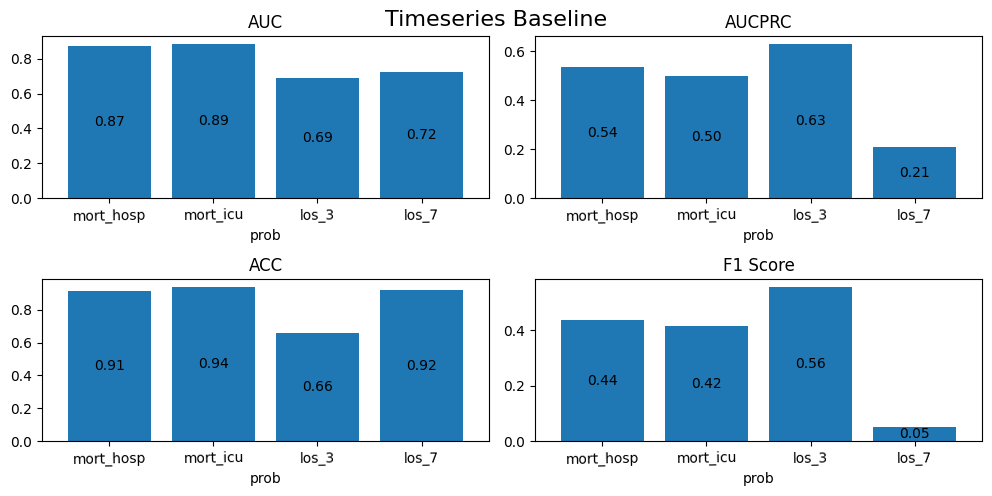

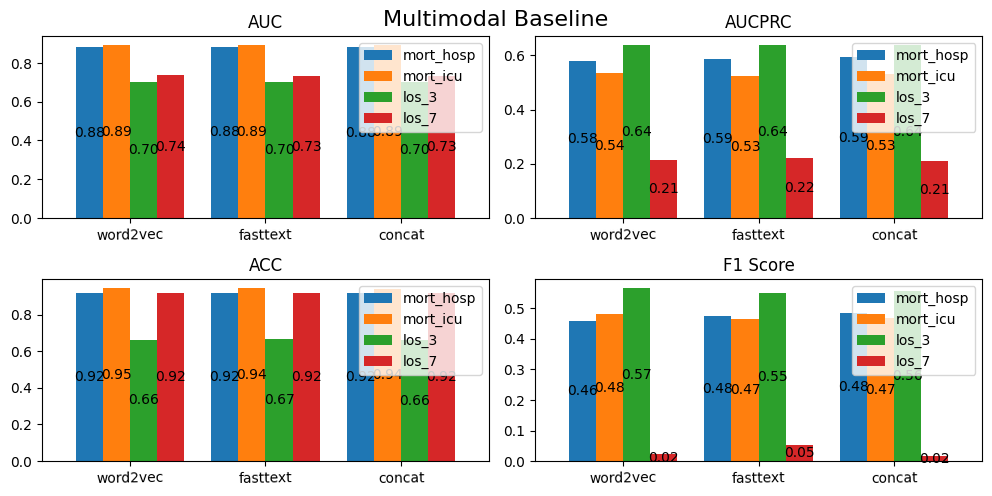

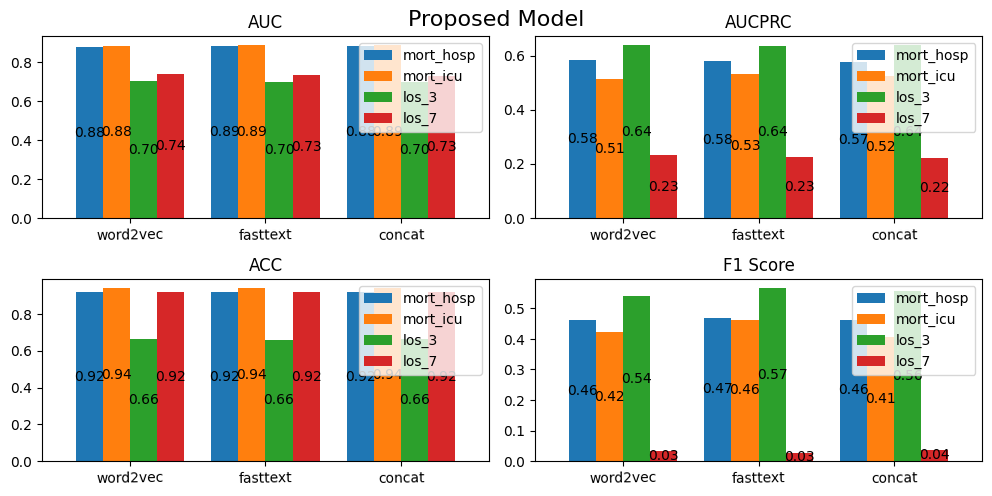

In [28]:
plot_model(time_data, 'timeseries')
plot_model(mutlimodal_data, 'multimodal')
plot_model(proposed_data, 'proposed')

### Baseline Model Performance Comparison
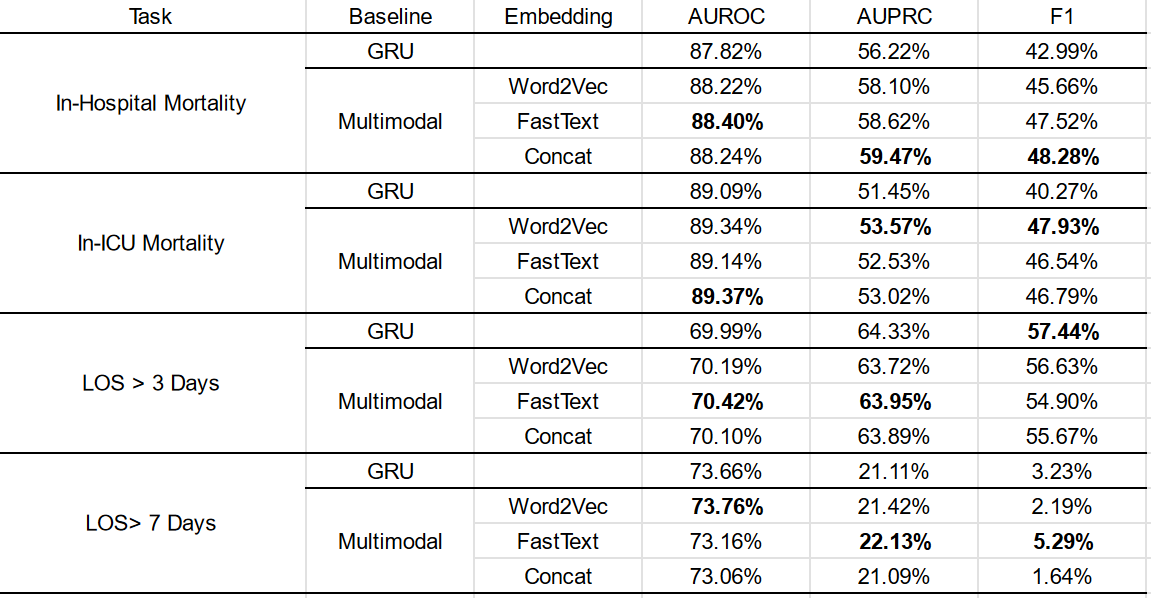

This table shows the baseline performance metrics for each task for the preloaded eval data.

### Proposed Model Performance Comparison vs Baseline
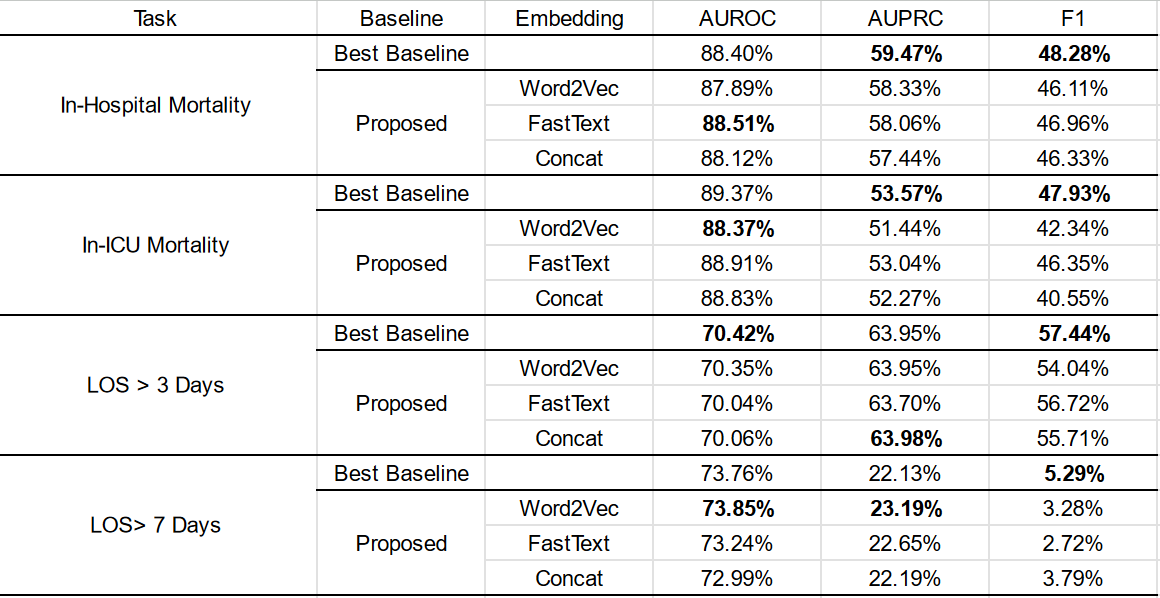

This table shows the performance metrics of the proposed model compared to the highest performing baseline model for each metric. The top performer in each category is in bold.

## Model comparison


Baseline Model Results:

The research paper evaluated four clinical tasks using ICU measurements and medical entities over the first 24 hours of ICU admission. The baseline methods incorporated a GRU (Gated Recurrent Unit) model and two multimodal approaches using Doc2Vec and averaged word embeddings. The multimodal approaches, which integrated medical entities with time-series patient features, generally outperformed the GRU time-series model.


*   In-hospital mortality prediction improved by approximately 1.5% in AUROC, 2.5% in AUPRC, and 4% in F1 score.
*   In-ICU mortality prediction saw roughly a 2% increase in AUROC and AUPRC, and a 7% increase in F1 score.
*   LOS predictions for >3 and >7 days both showed improvements of about 1.5% across all metrics, with the exception that the GRU model had a slightly better F1 score for LOS >7 days.
*   The performances of the Doc2Vec and averaged multimodal methods were similar, leading to the conclusion that a convolution-based deep multimodal model could be the most effective.



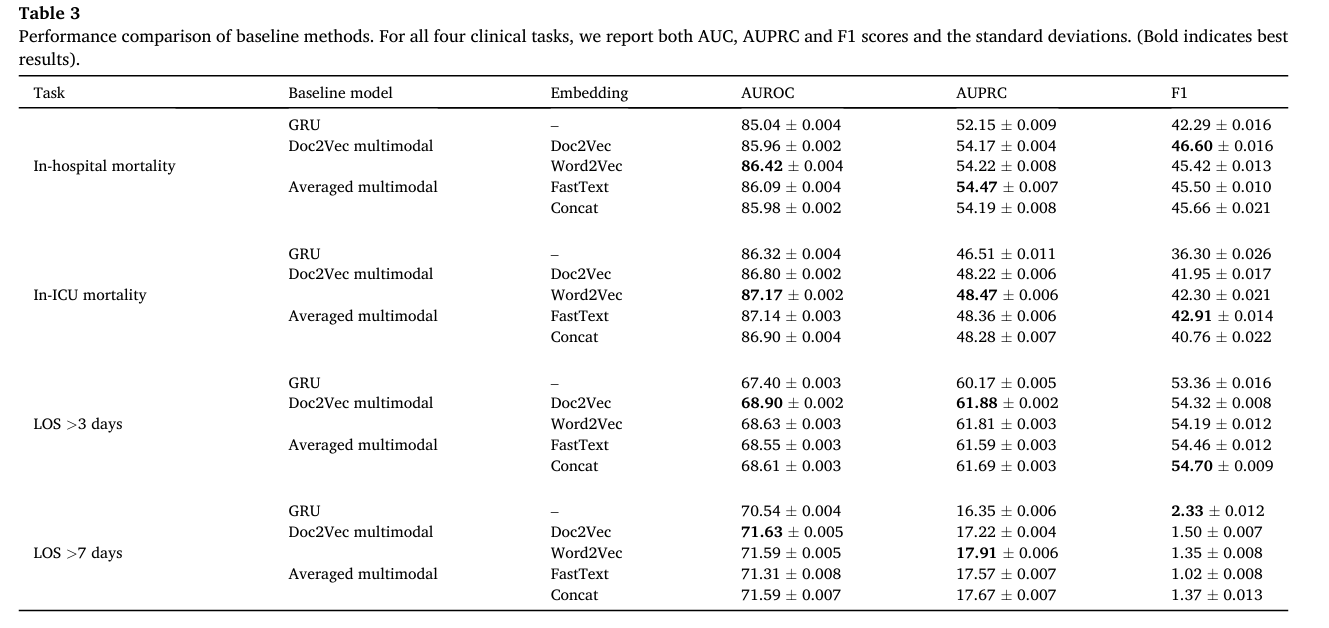


Proposed Model Results:

*   For in-hospital mortality, the proposed model showed improvement with Word2Vec embeddings, with AUROC reaching 87.55, AUPRC 55.68, and F1 46.87.
*   For in-ICU mortality, Word2Vec again led to the best results for the proposed model, with an AUROC of 88.35, AUPRC 49.23, and F1 43.02.
*   For predicting LOS >3 days, the proposed model with Word2Vec embeddings again had the highest scores with an AUROC of 69.54, AUPRC 62.68, and F1 55.04.
*   When predicting LOS >7 days, the proposed model with Word2Vec saw a slight improvement in AUROC and AUPRC but not in F1 score compared to the best baseline.




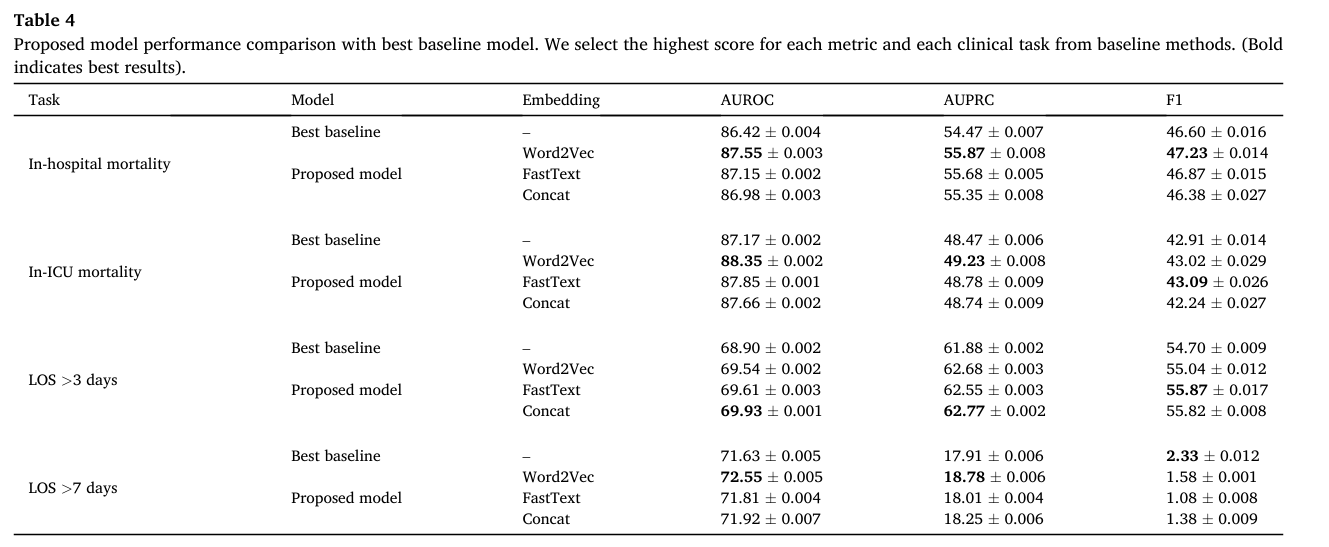

Overall, the proposed model consistently outperformed the baseline models in almost all metrics and tasks. demonstrating the efficacy of utilizing CNNs to capture local features from medical entities for improving clinical outcome predictions. The reliability of these models was validated by repeating experiments with different initializations and reporting average performance scores.

# Discussion



## Reproducability

We did not find the paper to be reproducable. The paper showed a conclusive advantage in the proposed model vs the baseline models for all 4 tasks. Our reproduction attempt did not find this. As seen in the "Proposed Model Performance Comparison vs Baseline" table, every task had at least one metric where a baseline model was the best performer.

We believe we had issues reproducing due to a number of typos and discrepancies found in the source code. For instance, in the 06-Create-Timeseries-Data pre-processing step which is linked to in the paper, the code wants to load a file called `"lvl2_imputer_test_"+str(SEED)+".pkl"` However, when this file is saved in step 1, no SEED is added to the file name. This means the code as provided is not runable. We made a number of changes like this to get the project in a runable state which may have contributed to the different results.

We also noticed that the paper reports 10 training iterations for the multimodal models, but only 2 iterations are specified in the source code. The paper also reports using a pretrained doc2vec model as well as the word embedding methods, but no model, or code related to doc2vec was provided.

Additionally, in the model definition and in some of the pre-processing scripts, there is a lot of commented code, which makes it difficult to understand which blocks of code the authors actually used originally.

Finally, no environment requirements were provided and the source code is years old, so it was difficult to find the correct versions of the packages needed. We did our best to leave the source code unchanged but were forced to make small changes (e.g. values instead of as_matrix) in order to run the provided code.

All of the above issues made our reproduction attempt rather difficult and tedious. Our recommendation to the authors would be to:
* Include environment info (python and package versions)
* Remove commented code if unneccessary, or add explanatory comments
* Double check that the parameters and methods reported in the paper match those provided in the source code
* Confirm that the source code can be run as-is



## Plans
We've successfully set up the pre-processing pipeline as well as the model definition, training and evaluation for
* The timeseries Baseline model
* The multimodal Baseline models (fasttext, word2vec, and the combined embedding)
* The proposed model

The remainder of our time will be spent continuing to flesh out the Results and Discussion Sections of our report. If possible We would like to include a dynamically generated table to report performance metrics instead of the static images provided in Figures section

We also need to create a formal 'Computational Requirements' section, to outline what expectations there are for the hardware needed to run this notebook.

Since we were unable to reproduce the paper results, we want to go back through our code and double check we aren't making any mistakes, as well as experiement with some of the typo fixes, parameter changes mentioned in the Reproducability section.

# References

[1] Bardak, Batuhan, and Mehmet Tan. “Improving clinical outcome predictions using convolution over medical entities with multimodal learning.” Artificial intelligence in medicine vol. 117 (2021): 102112. doi:10.1016/j.artmed.2021.102112

[2] Johnson, Alistair, et al. "MIMIC-III Clinical Database" (version 1.4). PhysioNet (2016), https://doi.org/10.13026/C2XW26.

[3] Shirly Wang, Matthew B. A. McDermott, Geeticka Chauhan, Michael C. Hughes, Tristan Naumann, and Marzyeh Ghassemi. MIMIC-Extract: A Data Extraction, Preprocessing, and Representation Pipeline for MIMIC-III. arXiv:1907.08322.

[4] Andrey Kormilitzin, Nemanja Vaci, Qiang Liu, and Alejo Nevado-Holgado. Med7: a transfer-
able clinical natural language processing model for electronic health records. arXiv preprint
arXiv:2003.01271, 2020.



